In [812]:
# imports
import numpy as np
import pandas as pd
import math

from typing import List

import wikipedia
from typing import List

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import silhouette_score
from itertools import product
from matplotlib.legend_handler import HandlerTuple

In [735]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, max_features=5000, stop_words='english', ngram_range=(1, 2))

In [736]:
def __get_articles(n_categories: int)->pd.DataFrame:
    results = __prepareNames(n_categories)
    lista = []
    titles = []
    failures = 0
    idxs = []
    for idx in range(0, len(results)):
        try:
            title = results['Article title'][idx]
            lista_add = wikipedia.page(f"{title}").content
            lista.append(lista_add)
            titles.append(wikipedia.page(results['Article title'][idx]).title)
            idxs.append(idx)
        except:
            print(f"Failed for: {results['Article title'][idx]}")
            failures += 1
            continue
    print(f'Failed for {failures} articles, succeeded for {len(titles)}')
    results = results.loc[idxs]
    results['Content'] = lista
    return results.sample(frac=1)

def __prepareNames(n: int) -> pd.DataFrame:
    categories = ["Warsaw School of Economics", "Data analysis", "Project management", "Public Relations", "History", "Classical Music", "Animal", "Engine", "Cosmetology", "Architecture", "Marvel", "Cooking"]
    if n<1 or n>len(categories):
        raise Exception(f"Podaj liczbę kategorii pomiędzy 1 a {len(categories)}")
    n_results = [1, 15, 13, 20, 47, 13, 31, 25, 17, 29, 14, 31]
    results = []
    results_categories=[]
    categories_id = []
    for i in range(0, n):
        new_ressults = wikipedia.search(categories[i], results = n_results[i])
        results += new_ressults
        results_categories += [categories[i]]*len(new_ressults)
        categories_id += [i]*len(new_ressults)
    results = pd.DataFrame({'Category':results_categories, 'Article title': results, 'Category_id': categories_id})

    return results

In [ ]:
def create_word_cloud(text_data):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                          max_words=100, contour_width=3, contour_color='steelblue')

    # Generate the word cloud from the text data
    wordcloud.generate(text_data)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
def add_statistics(records):
    records['word_count'] = records['Content'].apply(lambda x: len(str(x).split()))
    records['article_len'] = records['Content'].apply(lambda x: len(str(x)))

    features = ['word_count', 'article_len']
    titles = ['Word Count Distribution', 'Article length Distribution']
    colors = ['#9966ff', '#3399ff', '#00ff00', '#ff6600']
    df = records

    for feature, title, color in zip(features, titles, colors): 
        sns.distplot(x=df[feature], bins=50, color=color)
        plt.axvline(df[feature].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')  # Use axvline to show the mean
        # Add text annotation for the mean value
        plt.text(df[feature].mean(), plt.ylim()[1]*0.9, f"{df[feature].mean():.1f}", color='r', ha='right', va='center')
        plt.title(title, size=15)
        plt.xlabel(feature)
        plt.legend()
        plt.show()

In [ ]:
def tf_idf(data):
    print("Stop words: \n", tfidf_vectorizer.get_stop_words())
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['Content'])
    data["TF-IDF"] = tfidf_matrix.toarray().tolist()

    return tfidf_matrix

In [ ]:
def get_top_keywords_per_category(data, categories, n_terms, vectorizer):
    feature_names = vectorizer.get_feature_names()

    top_keywords_per_category = {}
    for category_id in categories.unique():
        # Filter records for the current category
        category_records = data[categories == category_id]

        tfidf_vectors = np.array(category_records["TF-IDF"].tolist())  # Convert the list of lists to a numpy array

        avg_tfidf = tfidf_vectors.mean(axis=0)

        # Sort the feature indices based on their average TF-IDF scores in the category
        top_indices = np.argsort(avg_tfidf)[-n_terms:]

        # Get the corresponding feature names (words) and their counts for the top indices
        top_words = [feature_names[idx] for idx in top_indices]
        top_counts = avg_tfidf[top_indices]

        category_name = data[categories == category_id]['Category'].iloc[0]

        top_keywords_per_category[category_id] = {"name": category_name, "words": top_words, "counts": top_counts}

    return top_keywords_per_category

def create_bars_top_names(data):
    top_keywords_per_category = get_top_keywords_per_category(data, data['Category_id'], 10, tfidf_vectorizer)
    for category_id, info in top_keywords_per_category.items():
        category_name = info["name"]
        top_words = info["words"]
        top_counts = info["counts"]

        plt.figure(figsize=(10, 6))
        plt.bar(top_words, top_counts)
        plt.xlabel('Top Words')
        plt.ylabel('TF-IDF Score')
        plt.title(f'Top Words in Category: {category_name}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [737]:
def get_top_keywords(data, categories, n_terms, vectorizer):
    feature_names = vectorizer.get_feature_names()  # Use get_feature_names_out() instead of get_feature_names()

    top_keywords_per_category = {}
    for category_id in categories.unique():
        # Filter records for the current category
        category_records = data[categories == category_id]

        # Get the TF-IDF vectors for the category
        tfidf_vectors = np.array(category_records["TF-IDF"].tolist())  # Convert the list of lists to a numpy array

        # Compute the average TF-IDF scores for each word in the category
        avg_tfidf = tfidf_vectors.mean(axis=0)

        # Sort the feature indices based on their average TF-IDF scores in the category
        top_indices = np.argsort(avg_tfidf)[-n_terms:]

        # Get the corresponding feature names (words) for the top indices
        top_words = [feature_names[idx] for idx in top_indices]

        # Get the category name and ID for the current category_id
        category_name = data[categories == category_id]['Category'].iloc[0]
    
        # Save the top words and category name in the DataFrame
        data.at[categories == category_id, "Top_Keywords"] = ", ".join(top_words)
        

        # Save the top words, category name, and category ID
        top_keywords_per_category[category_id] = {"name": category_name, "words": top_words}

     # Concatenate results for each category with line breaks
    result_str = "<br/>".join(
        f"Category ID: {category_id}\n Category Name: {info['name']}<br/>{', '.join(info['words'])}<br/>"
        for category_id, info in top_keywords_per_category.items()
    )

    return result_str

In [738]:
categories = [
        "Warsaw School of Economics", "Data analysis", "Project management", "Public Relations",
        "History", "Classical Music", "Animal", "Enigine", "Cosmetology", "Architecture", "Marvel", "Cooking"
    ]

# Calculate the average TF-IDF score for the given word in each article
def calculate_average_tfidf(records_tfidf, word):
    word_index = tfidf_vectorizer.vocabulary_.get(word.lower(), -1)
    if word_index == -1:
        raise ValueError(f"Word '{word}' not found in the TF-IDF vocabulary.")
    
    word_tfidf_scores = records_tfidf[:, word_index].toarray().flatten()
    return word_tfidf_scores

def tf_idf_top_words_all_categories(charts):
    top_keywords = get_top_keywords(charts, charts['Category_id'], 2, tfidf_vectorizer)

    for words in charts['Top_Keywords'].unique():

        all_words = words.split(",")
        if all_words[0].lower() in [x.lower() for x in categories]:
            word = all_words[1]
        else:
            word = all_words[0]
        word_to_plot = word #'data'
        average_tfidf_scores = calculate_average_tfidf(records_tfidf, word_to_plot)

        # Group the articles by category and calculate the average TF-IDF score for the word in each category
        charts['Average_TF-IDF'] = average_tfidf_scores
        average_tfidf_by_category = charts.groupby('Category')['Average_TF-IDF'].mean()

        # Convert the results to a DataFrame for plotting
        average_tfidf_df = average_tfidf_by_category.reset_index()

        # Create the line chart
        plt.figure(figsize=(10, 6))
        plt.plot(average_tfidf_df['Category'], average_tfidf_df['Average_TF-IDF'], marker='o', linestyle='-')
        plt.xlabel('Category')
        plt.ylabel('Average TF-IDF Score')
        plt.title(f'Average TF-IDF Score for the word "{word_to_plot}" in Different Categories')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [740]:
def bubble_chart_categories(records):
    categories = [
        "Warsaw School of Economics", "Data analysis", "Project management", "Public Relations",
        "History", "Classical Music", "Animal", "Engine", "Cosmetology", "Architecture", "Marvel", "Cooking"
    ]
    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    # pca_result = pca.fit_transform(tfidf_matrix.toarray())
    pca_result = pca.fit_transform(records_tfidf.toarray())

    # Add PCA results to DataFrame
    records['PCA1'] = pca_result[:, 0]
    records['PCA2'] = pca_result[:, 1]
    
    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(records_tfidf.toarray())

    # Add t-SNE results to DataFrame
    records['t-SNE1'] = tsne_result[:, 0]
    records['t-SNE2'] = tsne_result[:, 1]

    # Filter out rows with non-finite position coordinates
    records_pca = records[np.isfinite(records['PCA1']) & np.isfinite(records['PCA2'])]
    
    # Filter out rows with non-finite position coordinates
    records_tsne = records[np.isfinite(records['t-SNE1']) & np.isfinite(records['t-SNE2'])]


    # Create a categorical colormap for unique colors per category
    category_colors = sns.color_palette('hls', n_colors=len(categories))

    # Create Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = records_pca[records_pca['Category'] == category]
        plt.scatter(x=category_records['PCA1'], y=category_records['PCA2'], s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['PCA1'].mean(), category_records['PCA2'].mean(),
                 category, fontsize=12, ha='center', va='center')
    
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):   
        category_records = records_tsne[records_tsne['Category'] == category]
        plt.scatter(x=category_records['t-SNE1'], y=category_records['t-SNE2'], s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['t-SNE1'].mean(), category_records['t-SNE2'].mean(),
                 category, fontsize=12, ha='center', va='center')
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Bubble Chart for Records')
    plt.show()

In [ ]:
def __cluster_K_Means(records_tfidf: List[float], n_categories: int):
    return MiniBatchKMeans(n_clusters=n_categories).fit_predict(records_tfidf)

In [ ]:
def get_documents_in_clusters(data, categories, vectorizer):
    feature_names = vectorizer.get_feature_names()

    rows = []
    
    for category_id in categories.unique():
        category_name = data[categories == category_id]['Category'].iloc[0]
        
        documents_in_cluster = data.loc[categories == category_id]['Article title'].tolist()
        
        for title in documents_in_cluster:
            rows.append({'Category_id': category_id,'Category': category_name, 'Article Title': title})

    df = pd.DataFrame(rows)
    
    return df

In [ ]:
def calculate_elbow_score(data, max_clusters=12, scaled=False):
    inertias = []
    scaled_inertias = []
    inertia_o = np.square((data - data.mean(axis=0))).sum()
    alpha_k = 0.02

    for n_clusters in range(2, max_clusters + 1):
        kmeans = MiniBatchKMeans(n_clusters=n_clusters)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * n_clusters
        scaled_inertias.append(scaled_inertia)
        
    print("Wartości inertii: ", inertias)
    # Plotting the elbow curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.tight_layout()
    plt.show()
    
    print("Wartości zeskalowanych inertii: ", scaled_inertias)
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_clusters + 1), scaled_inertias, marker='o')
    plt.title('Elbow Method Scaled')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.tight_layout()
    plt.show()
    
    if scaled:
        return scaled_inertias
    else:
        return inertias

def calculate_silhouette_scores(data, max_clusters=12):
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = MiniBatchKMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

    # Plotting the silhouette scores
    print("Wartości skorów sylwetki: ", silhouette_scores)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    return silhouette_scores

def find_optimal_clusters_for_metric(data, score='silhouette', max_clusters=18):
    if score == 'elbow':
        scores = calculate_elbow_score(data, max_clusters, True)
        optimal_clusters_index = np.argmin(scores) + 2
    elif score == 'silhouette':
        scores = calculate_silhouette_scores(data, max_clusters)
        optimal_clusters_index = np.argmax(scores) + 2
    else:
        raise ValueError("Invalid score name. Choose 'elbow' or 'silhouette'.")

    return optimal_clusters_index

def find_optimal_clusters(data, max_clusters=18, silhouette_weight=0.5):
    silhouette_scores = calculate_silhouette_scores(data, max_clusters)
    elbow_scores = calculate_elbow_score(data, max_clusters, True)

    normalized_silhouette_scores = (silhouette_scores - min(silhouette_scores)) / (max(silhouette_scores) - min(silhouette_scores))
    normalized_elbow_scores = 1 - ((elbow_scores - min(elbow_scores)) / (max(elbow_scores) - min(elbow_scores)))

    hybrid_scores = silhouette_weight * normalized_silhouette_scores + (1 - silhouette_weight) * normalized_elbow_scores

    optimal_clusters_index = np.argmax(hybrid_scores) + 2

    return optimal_clusters_index

def cluster_K_Means(records_tfidf, silhouette_weight, score='silhouette'):
    optimal_clusters = find_optimal_clusters(records_tfidf, silhouette_weight=silhouette_weight)
    print("Optymalna liczba klastrów: ", optimal_clusters)

    kmeans = MiniBatchKMeans(n_clusters=optimal_clusters)
    
    return kmeans

In [777]:
def pca_kmeans(data):    
    df = pd.DataFrame(data)

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df['TF-IDF'].tolist())

    # Add PCA results to DataFrame
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df['TF-IDF'].tolist())

    # Add t-SNE results to DataFrame
    df['t-SNE1'] = tsne_result[:, 0]
    df['t-SNE2'] = tsne_result[:, 1]

    # Create a categorical colormap for unique colors per category
    categories = df['KM_Category'].unique()
    category_colors = sns.color_palette('hls', n_colors=len(categories))

    # Create PCA Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[df['KM_Category'] == category]
        plt.scatter(x=category_records['PCA1'], y=category_records['PCA2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['PCA1'].mean(), category_records['PCA2'].mean(),
                 category, fontsize=12, ha='center', va='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Bubble Chart for KM_Category')
    plt.legend()
    plt.show()

    # Create t-SNE Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[df['KM_Category'] == category]
        plt.scatter(x=category_records['t-SNE1'], y=category_records['t-SNE2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['t-SNE1'].mean(), category_records['t-SNE2'].mean(),
                 category, fontsize=12, ha='center', va='center')

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Bubble Chart for KM_Category')
    plt.show()


In [781]:
def dbscan_silhouette_based(cosine_similarities):

    # parameter grid
    eps_values = np.arange(0.1, 1.1, 0.1)
    min_samples_values = range(3, 20)

    # Store silhouette scores
    silhouette_scores = np.zeros((len(eps_values), len(min_samples_values)))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
            dbscan_labels = dbscan.fit_predict(cosine_similarities)

            if len(set(dbscan_labels)) > 1:  # Silhouette score requires at least 2 clusters
                silhouette_avg = silhouette_score(cosine_similarities, dbscan_labels, metric='cosine')
                silhouette_scores[i, j] = silhouette_avg

            else:
                silhouette_scores[i, j] = np.nan

    # Create a heatmap for silhouette scores
    plt.figure(figsize=(10, 8))
    plt.imshow(silhouette_scores, cmap='viridis', origin='lower', aspect='auto',
               extent=[min_samples_values[0], min_samples_values[-1], eps_values[0], eps_values[-1]])
    plt.colorbar(label='Silhouette Score')
    plt.xlabel('min_samples')
    plt.ylabel('eps')
    plt.title('Silhouette Score Heatmap')
    plt.xticks(min_samples_values, rotation=45)
    plt.yticks(eps_values)
    plt.show()


    # Continue with your existing code
    best_silhouette = -1
    best_params = None

    for eps, min_samples in product(eps_values, min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(cosine_similarities)

        if len(set(dbscan_labels)) > 1:  # Silhouette score requires at least 2 clusters
            silhouette_avg = silhouette_score(cosine_similarities, dbscan_labels, metric='cosine')

            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_params = {'eps': eps, 'min_samples': min_samples}

    print("Best parameters:", best_params)
    best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric='cosine')
    best_dbscan_labels = best_dbscan.fit_predict(cosine_similarities)


In [784]:
def dbscan_db_based(cosine_similarities):

    # Define the parameter grid
    eps_values = np.arange(0.1, 1.1, 0.1)
    min_samples_values = range(3, 20)

    # Store silhouette scores
    db_scores = np.zeros((len(eps_values), len(min_samples_values)))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
            dbscan_labels = dbscan.fit_predict(cosine_similarities)

            if len(set(dbscan_labels)) > 1:  # Silhouette score requires at least 2 clusters
                db_avg = db_score(cosine_similarities, dbscan_labels)
                db_scores[i, j] = db_avg

            else:
                db_scores[i, j] = np.nan 

    # Create a heatmap for Davies-Bouldin scores
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('viridis')
    im = plt.imshow(db_scores, cmap=cmap, origin='lower', aspect='auto',
                    extent=[min_samples_values[0], min_samples_values[-1], eps_values[0], eps_values[-1]])
    plt.colorbar(im, label='Davies-Bouldin Score')
    plt.xlabel('min_samples')
    plt.ylabel('eps')
    plt.title('Davies-Bouldin Heatmap')
    plt.xticks(min_samples_values, rotation=45)
    plt.yticks(eps_values)
    plt.tight_layout()  # Adjust layout to prevent clipping labels
    plt.show()

    # Continue with your existing code
    best_silhouette = float('inf') 
    best_params = None

    for eps, min_samples in product(eps_values, min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(cosine_similarities)

        if len(set(dbscan_labels)) > 1:  # Silhouette score requires at least 2 clusters
            silhouette_avg = db_score(cosine_similarities, dbscan_labels)

            if silhouette_avg < best_silhouette:
                best_silhouette = silhouette_avg
                best_params = {'eps': eps, 'min_samples': min_samples}

    print("Best parameters:", best_params)
    best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric='cosine')
    best_dbscan_labels = best_dbscan.fit_predict(cosine_similarities)


In [786]:
def calculate_db_scores(cosine_similarities):

    # Define the parameter grid
    eps_values = np.arange(0.1, 1.1, 0.1)
    min_samples_values = range(3, 20)

    # Store silhouette scores
    db_scores = np.zeros((len(eps_values), len(min_samples_values)))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
            dbscan_labels = dbscan.fit_predict(cosine_similarities)

            if len(set(dbscan_labels)) > 1:  # Silhouette score requires at least 2 clusters
                db_avg = db_score(cosine_similarities, dbscan_labels)
                db_scores[i, j] = db_avg

            else:
                db_scores[i, j] = np.nan 
                
    # Create a heatmap for Davies-Bouldin scores
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('viridis')
    im = plt.imshow(db_scores, cmap=cmap, origin='lower', aspect='auto',
                    extent=[min_samples_values[0], min_samples_values[-1], eps_values[0], eps_values[-1]])
    plt.colorbar(im, label='Davies-Bouldin Score')
    plt.xlabel('min_samples')
    plt.ylabel('eps')
    plt.title('Davies-Bouldin Heatmap')
    plt.xticks(min_samples_values, rotation=45)
    plt.yticks(eps_values)
    plt.tight_layout()  # Adjust layout to prevent clipping labels
    plt.show()
 
    return db_scores

def calculate_silhouette_scores(cosine_similarities):
    # Define the parameter grid
    eps_values = np.arange(0.1, 1.1, 0.1)
    min_samples_values = range(3, 20)

    # Store silhouette scores
    silhouette_scores = np.zeros((len(eps_values), len(min_samples_values)))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
            dbscan_labels = dbscan.fit_predict(cosine_similarities)

            if len(set(dbscan_labels)) > 1:  # Silhouette score requires at least 2 clusters
                silhouette_avg = silhouette_score(cosine_similarities, dbscan_labels, metric='cosine')
                silhouette_scores[i, j] = silhouette_avg

            else:
                silhouette_scores[i, j] = np.nan

    # Create a heatmap for silhouette scores
    plt.figure(figsize=(10, 8))
    plt.imshow(silhouette_scores, cmap='viridis', origin='lower', aspect='auto',
               extent=[min_samples_values[0], min_samples_values[-1], eps_values[0], eps_values[-1]])
    plt.colorbar(label='Silhouette Score')
    plt.xlabel('min_samples')
    plt.ylabel('eps')
    plt.title('Silhouette Score Heatmap')
    plt.xticks(min_samples_values, rotation=45)
    plt.yticks(eps_values)
    plt.show()

    return silhouette_scores


def find_optimal_index(data, max_clusters=18, silhouette_weight=0.5):
    cosine_similarities = cosine_similarity(records_tfidf)
    
    silhouette_scores = calculate_silhouette_scores(cosine_similarities)
    db_scores = calculate_db_scores(cosine_similarities)
    
    min_value = np.nanmin(silhouette_scores)
    max_value = np.nanmax(silhouette_scores)
    normalized_silhouette_scores = (silhouette_scores - min_value) / (max_value - min_value)
    min_value = np.nanmin(db_scores)
    max_value = np.nanmax(db_scores)
    normalized_db_scores = 1 - ((db_scores - min_value) / (max_value - min_value))

    hybrid_scores = silhouette_weight * normalized_silhouette_scores + (1 - silhouette_weight) * normalized_db_scores

    optimal_index = np.unravel_index(np.nanargmax(hybrid_scores), hybrid_scores.shape)

    return optimal_index

def cluster_DBSCAN(records_tfidf, silhouette_weight, score='silhouette'):
    optimal_idx = find_optimal_index(records_tfidf, silhouette_weight=silhouette_weight)
    # Get the corresponding eps and min_samples values
    matching_eps = eps_values[optimal_idx[0]]
    matching_min_samples = min_samples_values[optimal_idx[1]]

    print(f"For hybrid_scores maximum at index {optimal_idx}: eps={matching_eps:.2f}, min_samples={matching_min_samples}")
    dbscan = DBSCAN(eps=matching_eps, min_samples=matching_min_samples, metric='cosine')
    dbscan_labels = dbscan.fit_predict(cosine_similarities)
    
    return dbscan_labels

In [835]:
def pca_dbscan(charts2):

    df = pd.DataFrame(charts2)
    df['DBS_Category'] = df['DBS_Category'].fillna('Missing')
    # Create a new category for the -1 cluster
    df.loc[df['DBS_Category'] == -1, 'DBS_Category'] = 'Missing'

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df['TF-IDF'].tolist())

    # Add PCA results to DataFrame
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df['TF-IDF'].tolist())

    # Add t-SNE results to DataFrame
    df['t-SNE1'] = tsne_result[:, 0]
    df['t-SNE2'] = tsne_result[:, 1]

    categories = df['DBS_Category'].unique()

    category_colors = sns.color_palette('hls', n_colors=len(categories))
    # Set the color for the -1 cluster to be grey
    category_colors[3] = 'grey'


    # Create PCA Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[df['DBS_Category'] == category]
        plt.scatter(x=category_records['PCA1'], y=category_records['PCA2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['PCA1'].mean(), category_records['PCA2'].mean(),
                 category, fontsize=12, ha='center', va='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Bubble Chart for DBS_Category')
    # plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create the custom legend handler
    handler_map = {tuple: HandlerTuple(ndivide=None)}

    # Create the legend with the custom handler map
    plt.legend(handles, labels, handler_map=handler_map, markerscale=0.5)
    plt.show()

    # Create t-SNE Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[df['DBS_Category'] == category]
        plt.scatter(x=category_records['t-SNE1'], y=category_records['t-SNE2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['t-SNE1'].mean(), category_records['t-SNE2'].mean(),
                 category, fontsize=12, ha='center', va='center')

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Bubble Chart for DBS_Category')
    # Get the handles and labels from the plot
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create the custom legend handler
    handler_map = {tuple: HandlerTuple(ndivide=None)}

    # Create the legend with the custom handler map
    plt.legend(handles, labels, handler_map=handler_map, markerscale=0.5)

    plt.show()

In [814]:
def pca_dbscan_with_noise(data):
    df = pd.DataFrame(data)

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df['TF-IDF'].tolist())

    # Add PCA results to DataFrame
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df['TF-IDF'].tolist())

    # Add t-SNE results to DataFrame
    df['t-SNE1'] = tsne_result[:, 0]
    df['t-SNE2'] = tsne_result[:, 1]

    # Create a categorical colormap for unique colors per category
    categories = df['DBS_Category'].unique()
    category_colors = sns.color_palette('hls', n_colors=len(categories))

    # Create PCA Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[df['DBS_Category'] == category]
        plt.scatter(x=category_records['PCA1'], y=category_records['PCA2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['PCA1'].mean(), category_records['PCA2'].mean(),
                 category, fontsize=12, ha='center', va='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Bubble Chart for DBS_Category')
    plt.legend()
    plt.show()

    # Create t-SNE Bubble Chart
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[df['DBS_Category'] == category]
        plt.scatter(x=category_records['t-SNE1'], y=category_records['t-SNE2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=category)
        plt.text(category_records['t-SNE1'].mean(), category_records['t-SNE2'].mean(),
                 category, fontsize=12, ha='center', va='center')

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Bubble Chart for DBS_Category')
    plt.show()


In [824]:
def pca_dbscan_noise(data):
    # PCA and tSNE ONLY for Missing category
    
    df = pd.DataFrame(data)

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df['TF-IDF'].tolist())

    # Add PCA results to DataFrame
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df['TF-IDF'].tolist())

    # Add t-SNE results to DataFrame
    df['t-SNE1'] = tsne_result[:, 0]
    df['t-SNE2'] = tsne_result[:, 1]

    # Create a categorical colormap for unique colors per category
    categories = df['DBS_Category'].unique()
    category_colors = sns.color_palette('hls', n_colors=len(categories))

    # Create PCA Bubble Chart for Missing category
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[(df['DBS_Category'] == 'Missing') & (df['Category'] == category)]
        plt.scatter(x=category_records['PCA1'], y=category_records['PCA2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=f'{category}')
        plt.text(category_records['PCA1'].mean(), category_records['PCA2'].mean(),
                 f'{category}', fontsize=12, ha='center', va='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Bubble Chart for Missing Category')
    handles, labels = plt.gca().get_legend_handles_labels()
    handler_map = {tuple: HandlerTuple(ndivide=None)}
    plt.legend(handles, labels, handler_map=handler_map, markerscale=0.5)
    plt.show()

    # Create t-SNE Bubble Chart for Missing category
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_records = df[(df['DBS_Category'] == 'Missing') & (df['Category'] == category)]
        plt.scatter(x=category_records['t-SNE1'], y=category_records['t-SNE2'],
                    s=category_records['Content'].str.len() * 0.05,
                    alpha=0.5, c=[category_colors[i]], label=f'{category}')
        plt.text(category_records['t-SNE1'].mean(), category_records['t-SNE2'].mean(),
                 f'{category}', fontsize=12, ha='center', va='center')

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Bubble Chart for Missing Category')
    handles, labels = plt.gca().get_legend_handles_labels()
    handler_map = {tuple: HandlerTuple(ndivide=None)}
    plt.legend(handles, labels, handler_map=handler_map, markerscale=0.5)
    plt.show()


In [832]:
def calculate_metrics(df):

    # Convert 'TF-IDF' column to numeric values
    data = np.array(df['TF-IDF'].values.tolist())
    
    # Encode cluster assignments as labels for evaluation metrics
    le = LabelEncoder()
    kmeans_labels = le.fit_transform(df['K-Means_Cluster_assignment'])
    dbscan_labels = le.fit_transform(df['dbs'])
    ground_truth_labels = le.fit_transform(df['Category_id'])

    # Calculate Silhouette Score
    kmeans_silhouette = silhouette_score(data, kmeans_labels)
    dbscan_silhouette = silhouette_score(cosine_similarities, dbscan_labels, metric='cosine')

    # Calculate Davies-Bouldin Index
    kmeans_davies_bouldin = davies_bouldin_score(data, kmeans_labels)
    dbscan_davies_bouldin = davies_bouldin_score(cosine_similarities, dbscan_labels)

    # Calculate Adjusted Rand Index
    adjusted_rand_kmeans = adjusted_rand_score(df['Category'], kmeans_labels)
    adjusted_rand_dbscan = adjusted_rand_score(df['Category'], dbscan_labels)

    # Calculate Normalized Mutual Information
    nmi_kmeans = normalized_mutual_info_score(df['Category'], kmeans_labels)
    nmi_dbscan = normalized_mutual_info_score(df['Category'], dbscan_labels)


    # Calculate Adjusted Mutual Information
    adjusted_mutual_info_kmeans = adjusted_mutual_info_score(ground_truth_labels, kmeans_labels)
    adjusted_mutual_info_dbscan = adjusted_mutual_info_score(ground_truth_labels, dbscan_labels)

    # Calculate Homogeneity Score
    homogeneity_kmeans = homogeneity_score(ground_truth_labels, kmeans_labels)
    homogeneity_dbscan = homogeneity_score(ground_truth_labels, dbscan_labels)

    # Calculate Completeness Score
    completeness_kmeans = completeness_score(ground_truth_labels, kmeans_labels)
    completeness_dbscan = completeness_score(ground_truth_labels, dbscan_labels)

    # Calculate V-Measure Score
    v_measure_kmeans = v_measure_score(ground_truth_labels, kmeans_labels)
    v_measure_dbscan = v_measure_score(ground_truth_labels, dbscan_labels)


    # Print the scores
    print("K-Means Scores:")
    print("Silhouette Score:", kmeans_silhouette)
    print("Davies-Bouldin Index:", kmeans_davies_bouldin)
    print("Adjusted Rand Index:", adjusted_rand_kmeans)
    print("Normalized Mutual Information:", nmi_kmeans)
    print()
    print("Adjusted Mutual Information:", adjusted_mutual_info_kmeans)
    print("Homogeneity Score:", homogeneity_kmeans)
    print("Completeness Score:", completeness_kmeans)
    print("V-Measure Score:", v_measure_kmeans)
    print()

    print("DBSCAN Scores:")
    print("Silhouette Score:", dbscan_silhouette)
    print("Davies-Bouldin Index:", dbscan_davies_bouldin)
    print("Adjusted Rand Index:", adjusted_rand_dbscan)
    print("Normalized Mutual Information:", nmi_dbscan)
    print()
    print("Adjusted Mutual Information:", adjusted_mutual_info_dbscan)
    print("Homogeneity Score:", homogeneity_dbscan)
    print("Completeness Score:", completeness_dbscan)
    print("V-Measure Score:", v_measure_dbscan)

In [749]:
n_categories = 12
records = __get_articles(n_categories)

Failed for: Data
Failed for: Data mining
Failed for: Public Relations (disambiguation)
Failed for: Fashion
Failed for: History of India
Failed for: World history
Failed for: SAMPLE history
Failed for: History of Romania
Failed for: History of the Virgin Islands
Failed for: Novel
Failed for: History of science
Failed for: IOS version history
Failed for: Classical music (disambiguation)
Failed for: Animal (disambiguation)
Failed for: Animal Farm
Failed for: Animal rights
Failed for: Animal Crossing
Failed for: Livestock
Failed for: Animal Kingdom
Failed for: Spirit animal
Failed for: Political animal
Failed for: Animal sex
Failed for: Fisher (animal)
Failed for: Unreal Engine
Failed for: Search engine
Failed for: Jet engine
Failed for: Chevrolet straight-6 engine
Failed for: Caroline Hirons
Failed for: Zari Hassan
Failed for: Soviet architecture
Failed for: Art Deco
Failed for: Processor architecture
Failed for: Googie architecture
Failed for: Marvel
Failed for: Characters of the Marvel 

In [750]:
records.head()

Category                      Article title  Category_id  \
248             Cooking  List of food preparation utensils           11   
49              History                            History            4   
251             Cooking              High-altitude cooking           11   
28   Project management         Float (project management)            2   
145              Engine         Search engine optimization            7   

                                               Content  
248  A kitchen utensil is a hand-held, typically sm...  
49   History (derived from Ancient Greek  ἱστορία (...  
251  High-altitude cooking is cooking done at altit...  
28   In project management, float or slack is the a...  
145  Search engine optimization (SEO) is the proces...

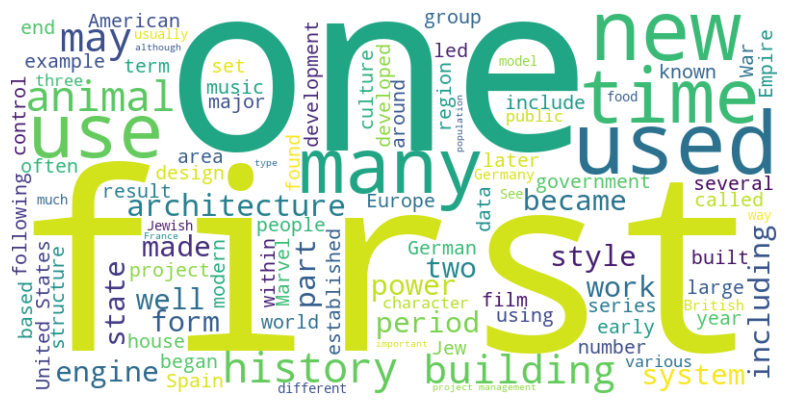

In [751]:
# Concatenate the text content from all the articles
text_data = " ".join(records['Content'])

create_word_cloud(text_data)

Warsaw School of Economics


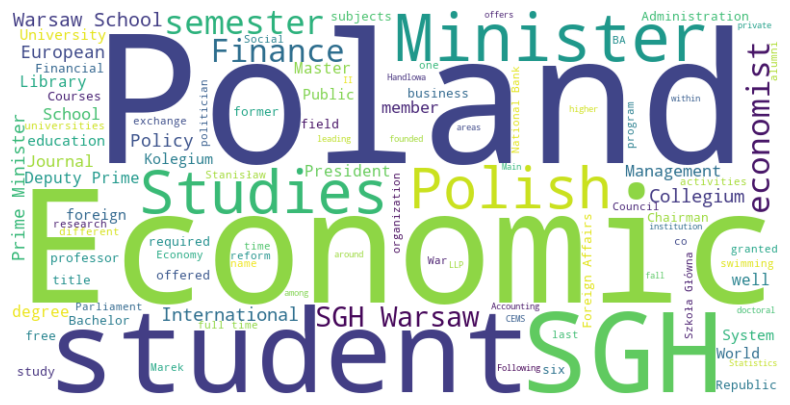

Data analysis


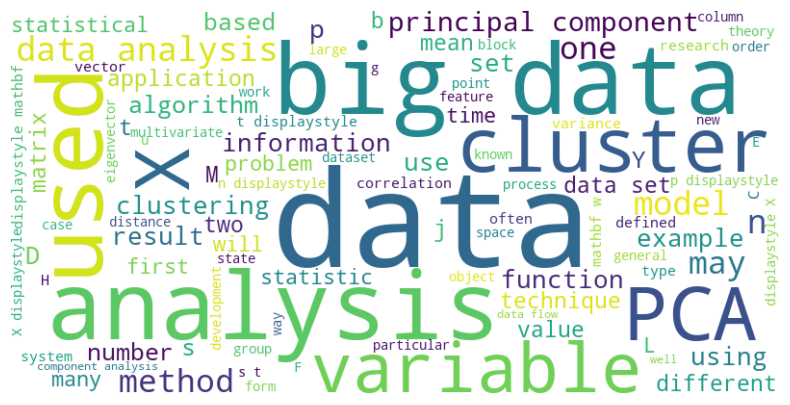

Project management


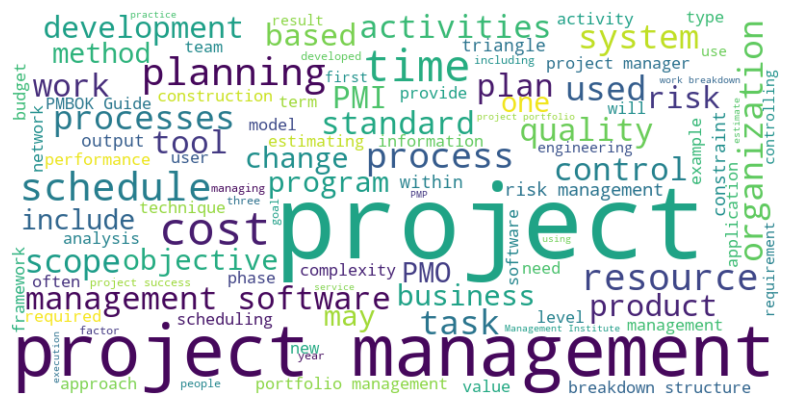

Public Relations


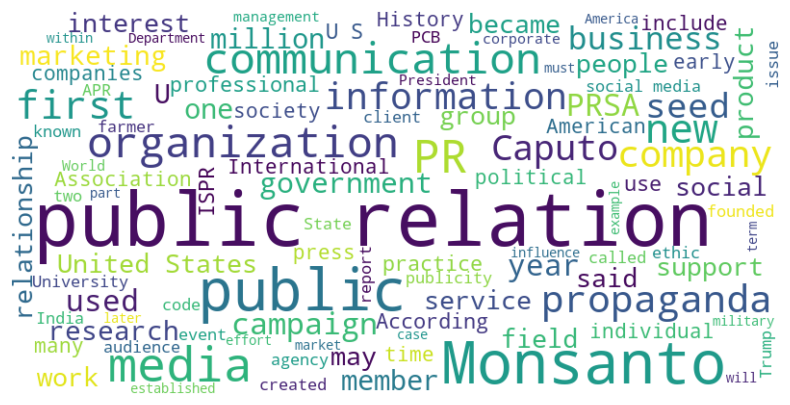

History


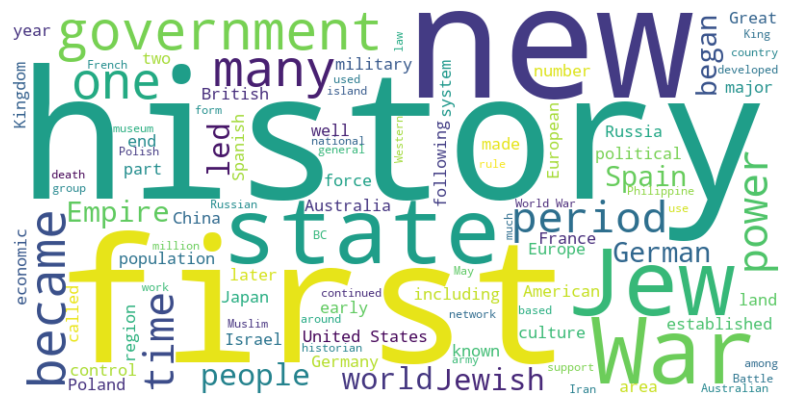

Classical Music


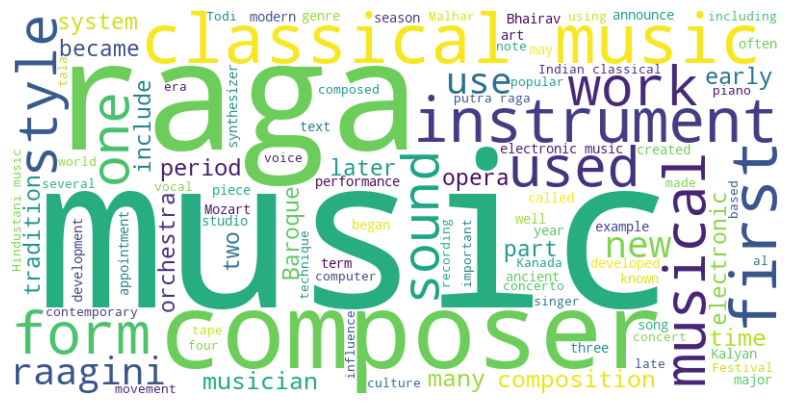

Animal


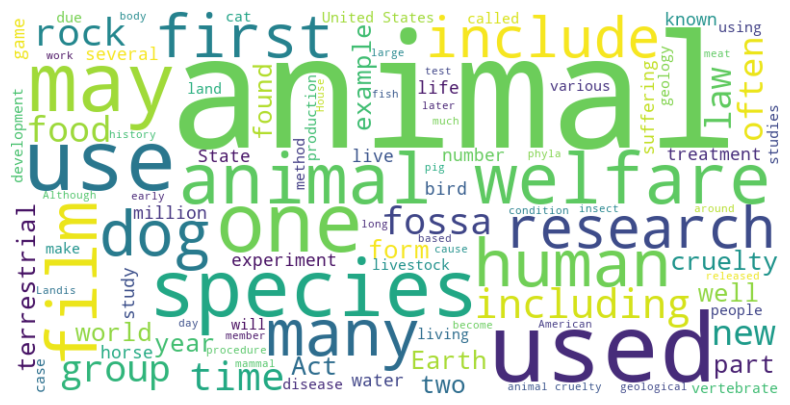

Engine


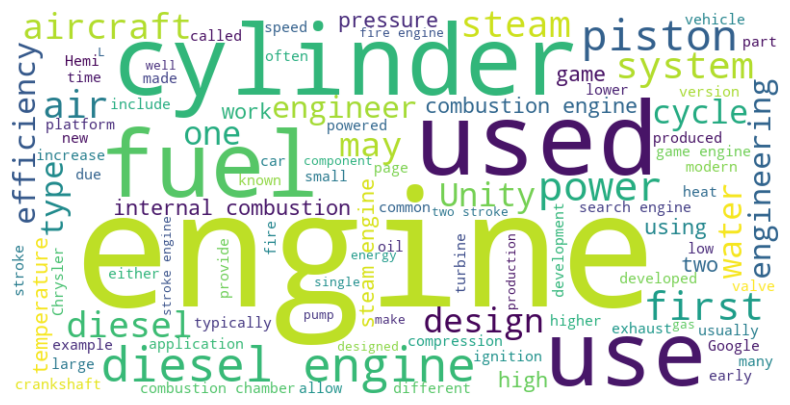

Cosmetology


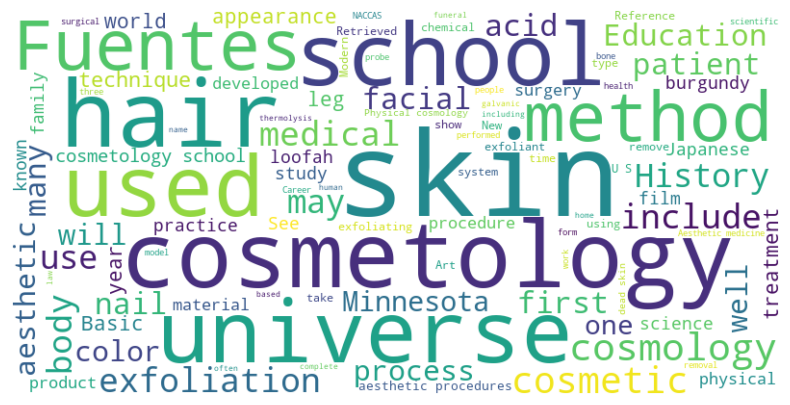

Architecture


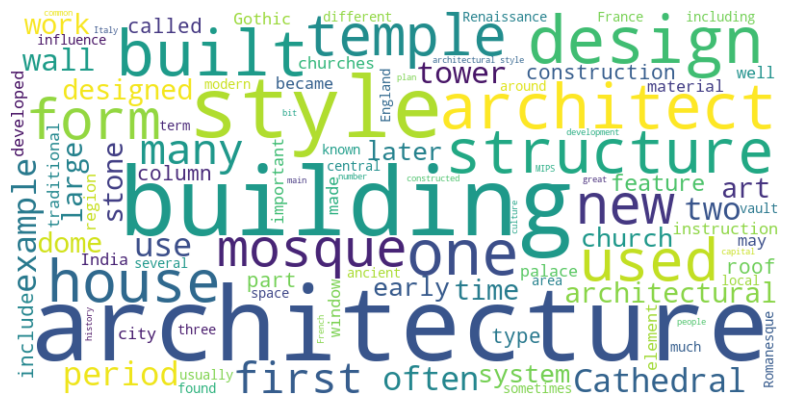

Marvel


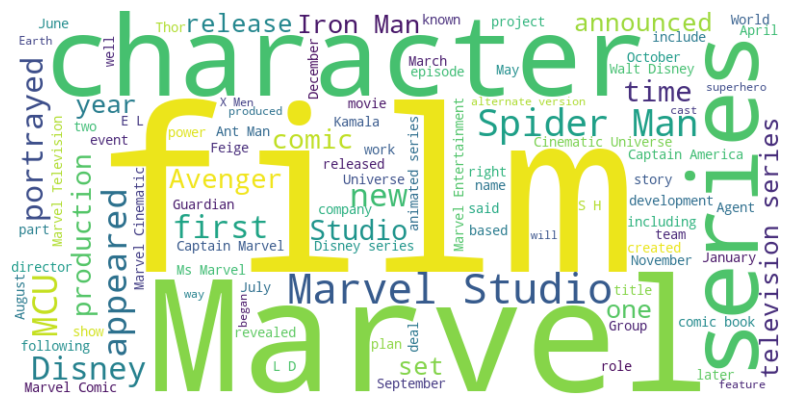

Cooking


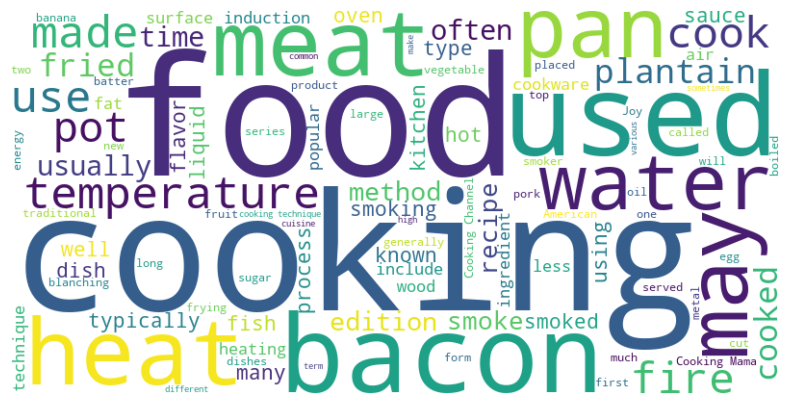

In [752]:
categories = ["Warsaw School of Economics", "Data analysis", "Project management", "Public Relations", "History", "Classical Music", "Animal", "Engine", "Cosmetology", "Architecture", "Marvel", "Cooking"]

for cat in categories:
    text_data = " ".join(records.loc[records['Category'] == cat]['Content'])

    print(cat)
    create_word_cloud(text_data)

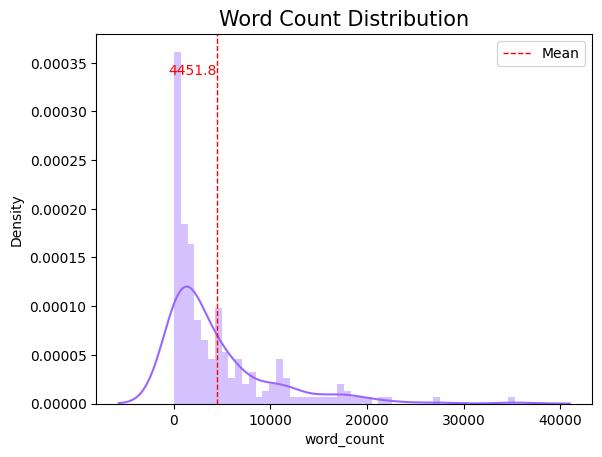

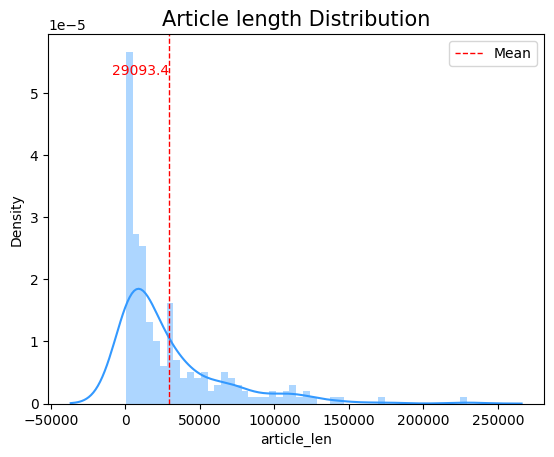

In [753]:
data = records.copy()

add_statistics(data)

In [754]:
records_tfidf = tf_idf(records)

Stop words: 
 frozenset({'such', 'except', 'so', 'your', 'cant', 'mine', 'me', 'wherever', 'once', 'in', 'a', 'again', 'go', 'thereafter', 'after', 'four', 'detail', 'beside', 'take', 'and', 'beyond', 'then', 'nevertheless', 'an', 'whither', 'whereupon', 'whether', 'system', 'see', 'before', 'often', 'though', 'neither', 'please', 'fire', 'toward', 'which', 'couldnt', 'besides', 'over', 'because', 'back', 'the', 'else', 'formerly', 'between', 'becoming', 'out', 'where', 'thin', 'serious', 'perhaps', 'much', 'give', 'while', 'nine', 'noone', 'myself', 'therein', 'moreover', 'towards', 'with', 'even', 'its', 'per', 'should', 'also', 'if', 'etc', 'becomes', 'show', 'either', 'yet', 'amoungst', 'every', 'last', 'seemed', 'amongst', 'eg', 'he', 'fifty', 'do', 'than', 'have', 'is', 'elsewhere', 'nothing', 'move', 'around', 'from', 'everywhere', 'few', 'somewhere', 'side', 'forty', 'any', 'front', 'my', 'could', 'to', 'inc', 'twelve', 'whereas', 'onto', 'these', 'she', 'had', 'de', 'under', '

In [755]:
records.head(20)

Category                                      Article title  \
248             Cooking                  List of food preparation utensils   
49              History                                            History   
251             Cooking                              High-altitude cooking   
28   Project management                         Float (project management)   
145              Engine                         Search engine optimization   
87              History                       History of the World, Part I   
127              Animal                                 Terrestrial animal   
149              Engine                                      Petrol engine   
167         Cosmetology                                Funeral cosmetology   
50              History          HIStory: Past, Present and Future, Book I   
108     Classical Music                           Andalusi classical music   
161              Engine                   List of Volkswagen Group engines   
74              History                              History of philosophy   
134              Animal                                          Animalize   
173         Cosmetology  National Accrediting Commission of Cosmetology...   
153              Engine                         Internal combustion engine   
238             Cooking                                      Cooking Light   
103     Classical Music                                   History of music   
68              History                                   History of Spain   
65              History                      History of the Jews in Poland   

     Category_id                                            Content  \
248           11  A kitchen utensil is a hand-held, typically sm...   
49             4  History (derived from Ancient Greek  ἱστορία (...   
251           11  High-altitude cooking is cooking done at altit...   
28             2  In project management, float or slack is the a...   
145            7  Search engine optimization (SEO) is the proces...   
87             4  History of the World, Part I is a 1981 America...   
127            6  Terrestrial animals are animals that live pred...   
149            7  A petrol engine (gasoline engine in American a...   
167            8  Funeral cosmetology, also known as mortuary ma...   
50             4  HIStory: Past, Present and Future, Book I is t...   
108            5  Andalusi classical music (Arabic: طرب أندلسي, ...   
161            7  This list of Volkswagen Group engines includes...   
74             4  The history of philosophy is the systematic st...   
134            6  Animalize is the twelfth studio album by Ameri...   
173            8  The National Accrediting Commission of Career ...   
153            7  An internal combustion engine (ICE or IC engin...   
238           11  Cooking Light was an American monthly food and...   
103            5  Although definitions of music vary wildly thro...   
68             4  The history of Spain dates to contact the pre-...   
65             4  The history of the Jews in Poland dates back a...   

                                                TF-IDF  
248  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
49   [0.004529876908843396, 0.0, 0.0, 0.0, 0.0, 0.0...  
251  [0.0975356877795694, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
28   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0266081023714...  
145  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
87   [0.014729037250233008, 0.0, 0.0, 0.0, 0.0, 0.0...  
127  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
149  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
167  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
50   [0.04964035010088745, 0.0, 0.0, 0.0, 0.0, 0.0,...  
108  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
161  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
74   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
134  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
173  [0.0393651274315, 0.0, 0

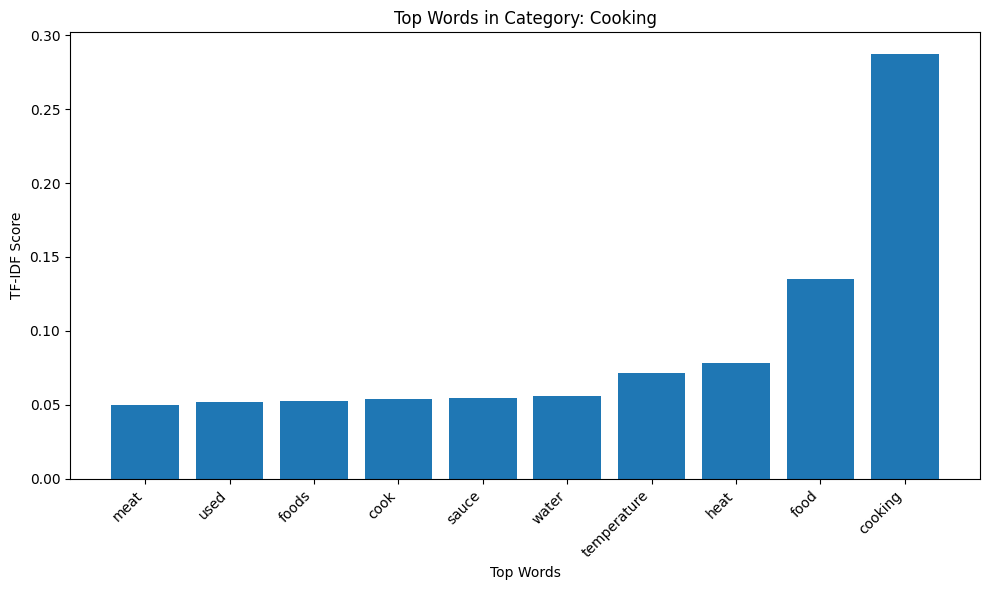

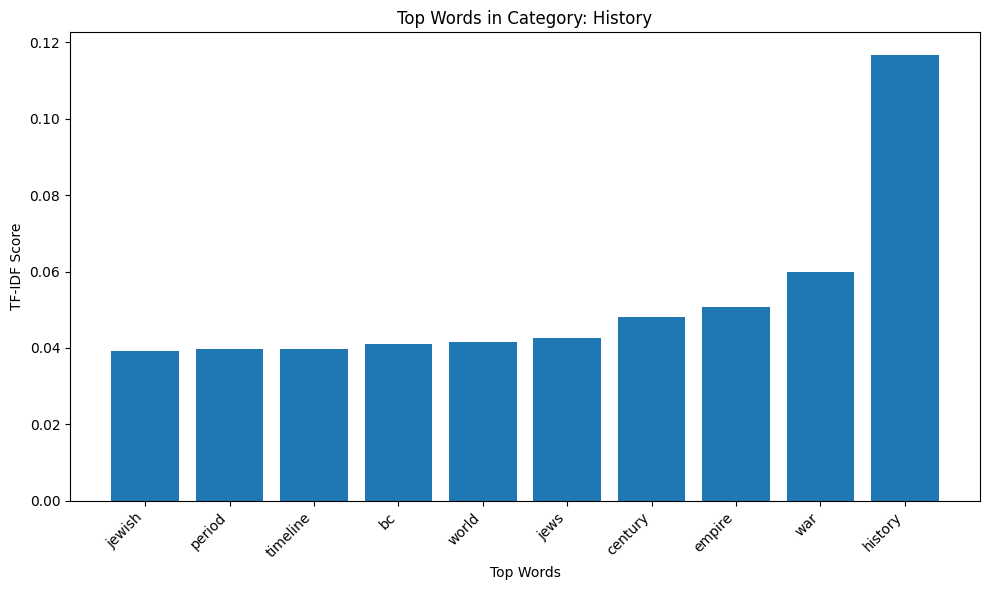

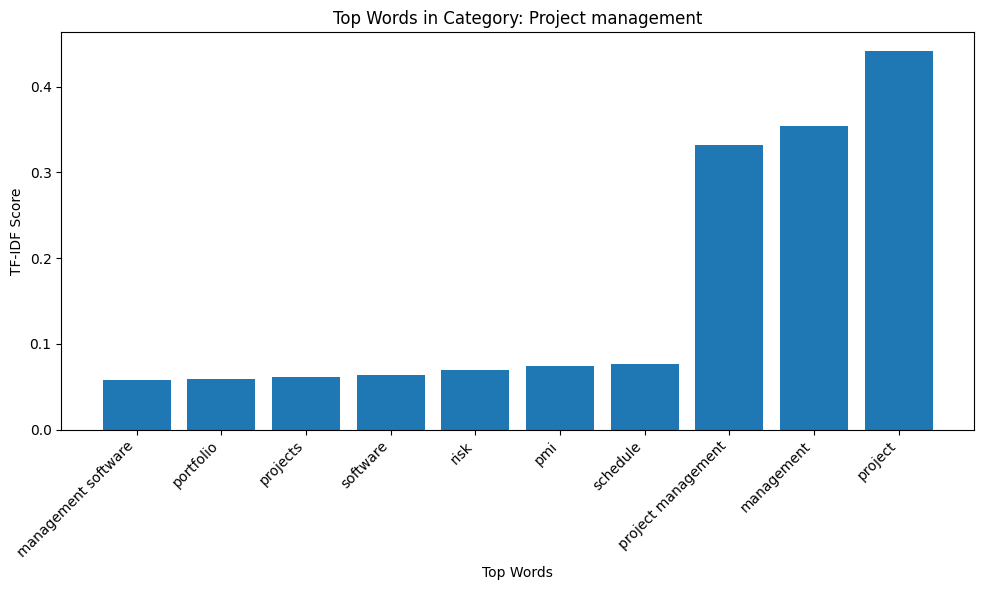

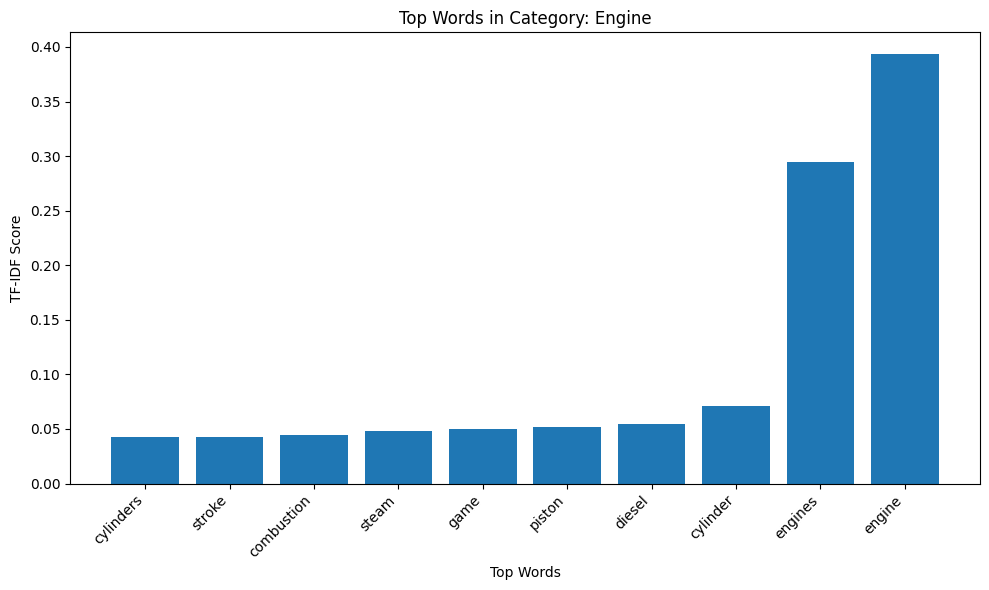

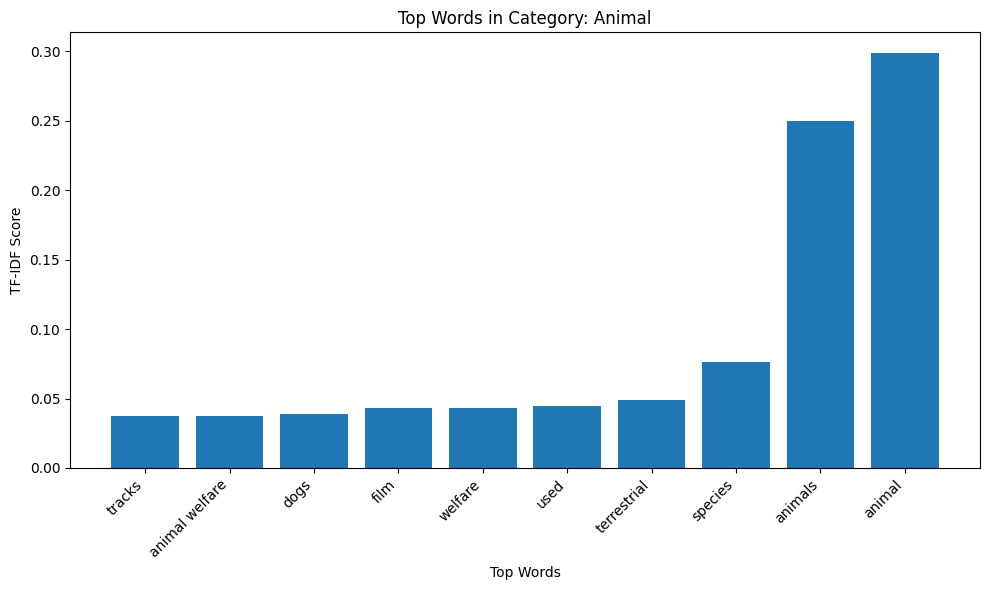

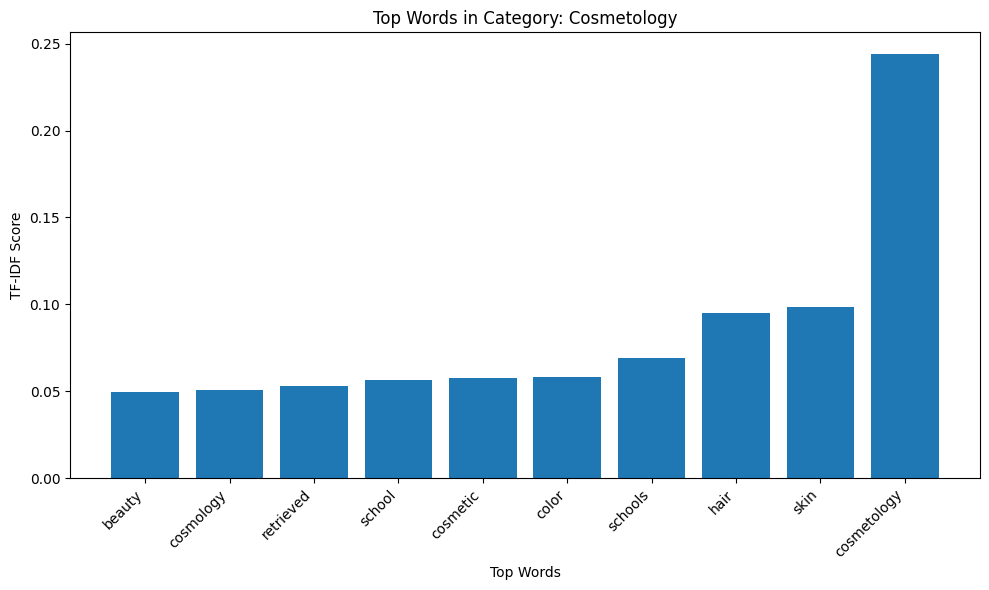

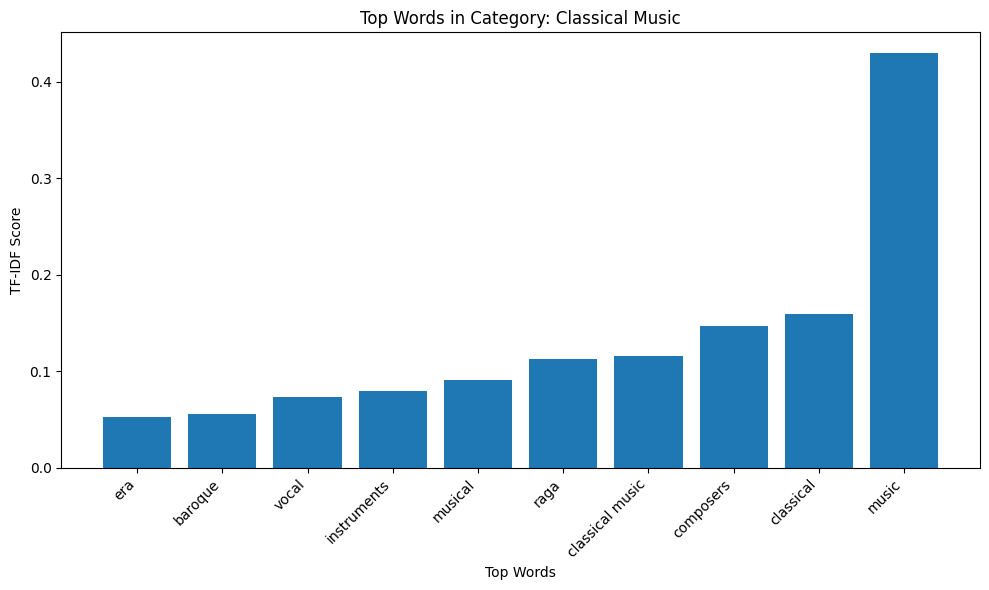

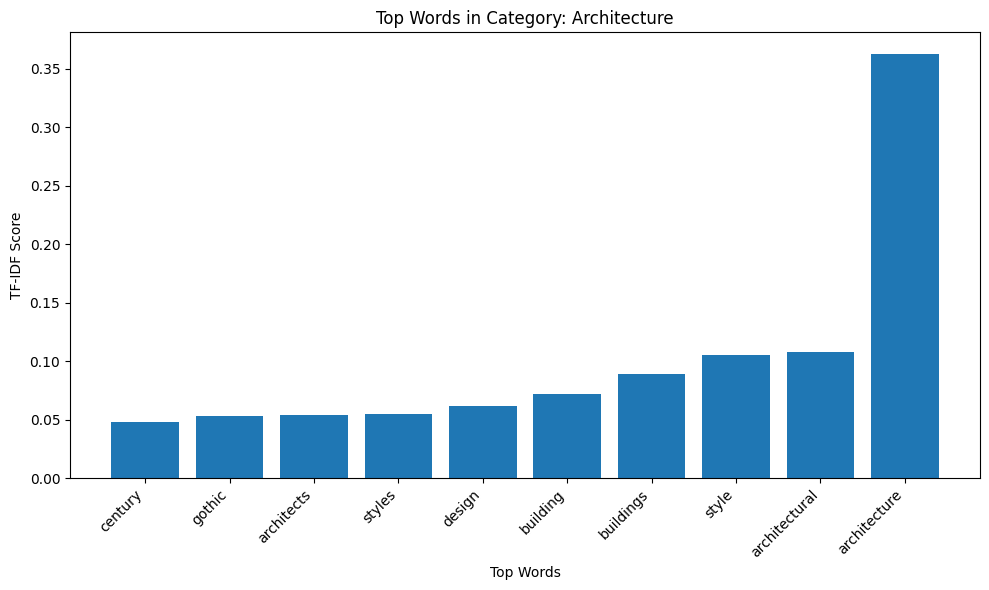

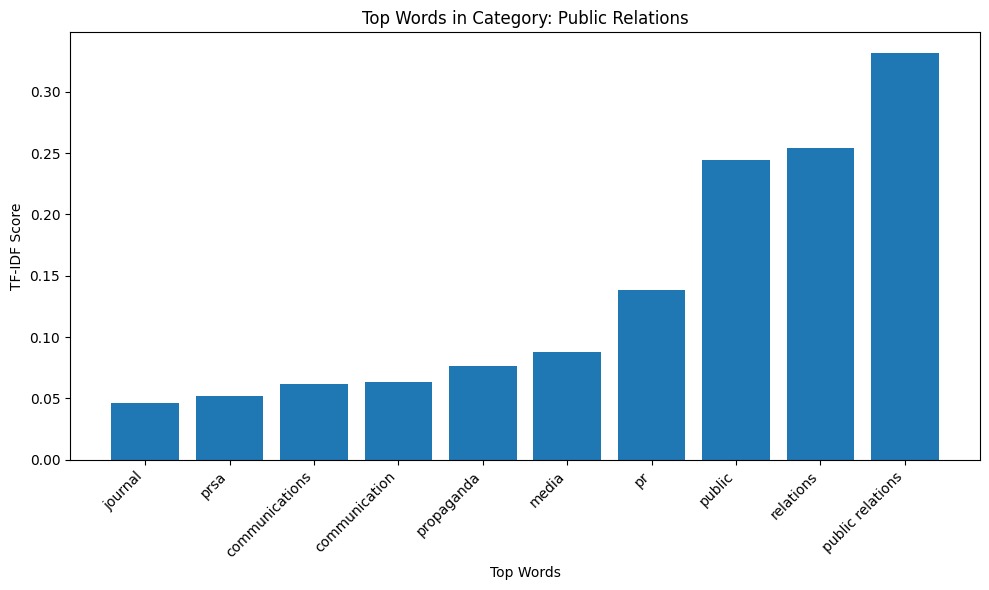

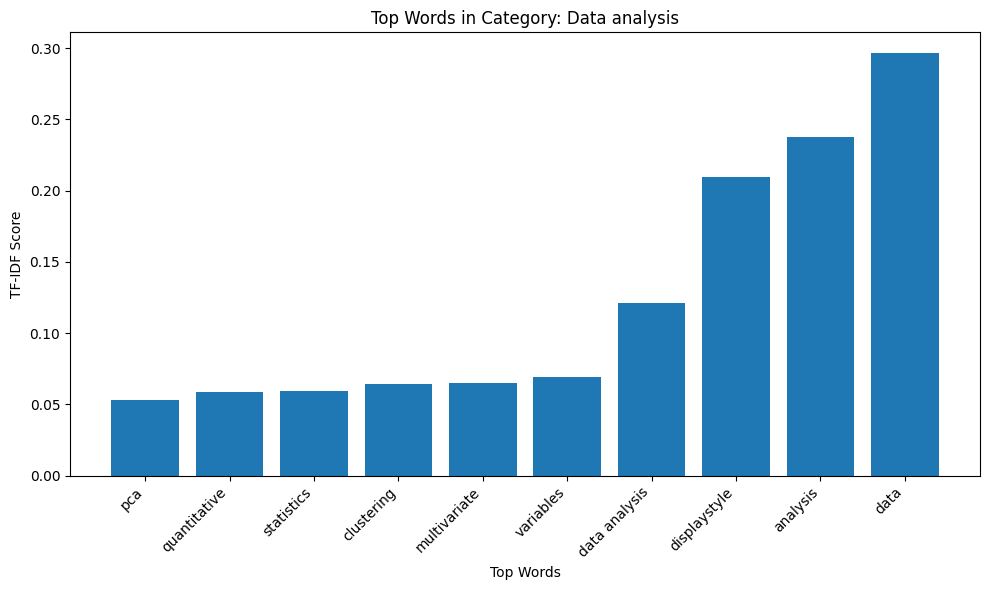

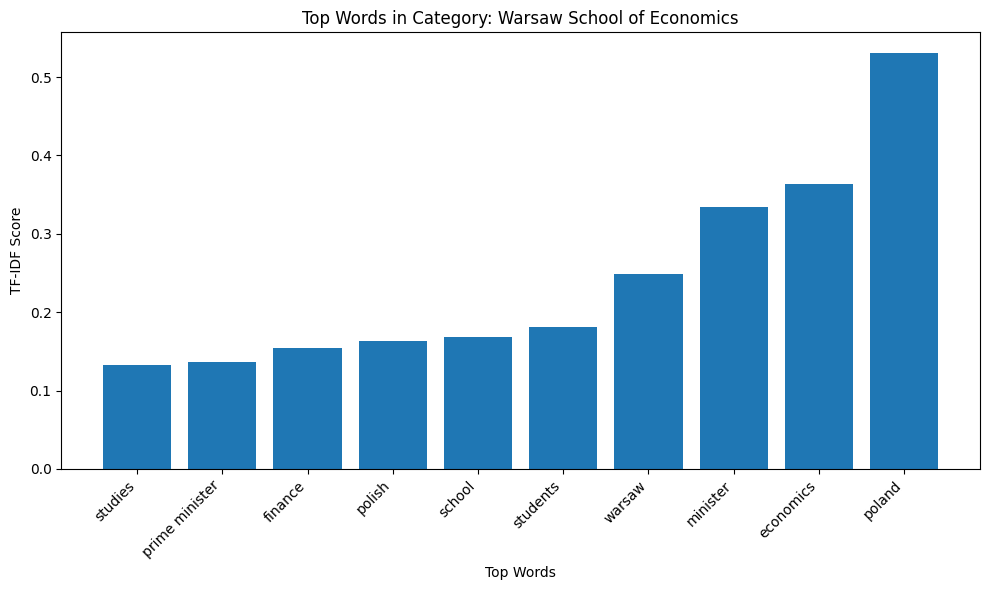

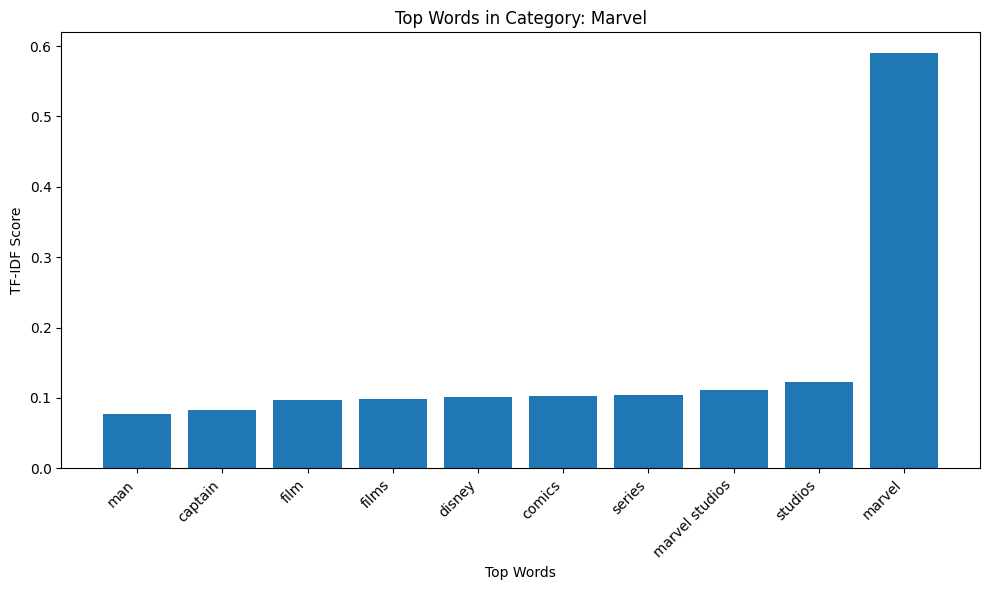

In [756]:
data = records.copy()
create_bars_top_names(data)

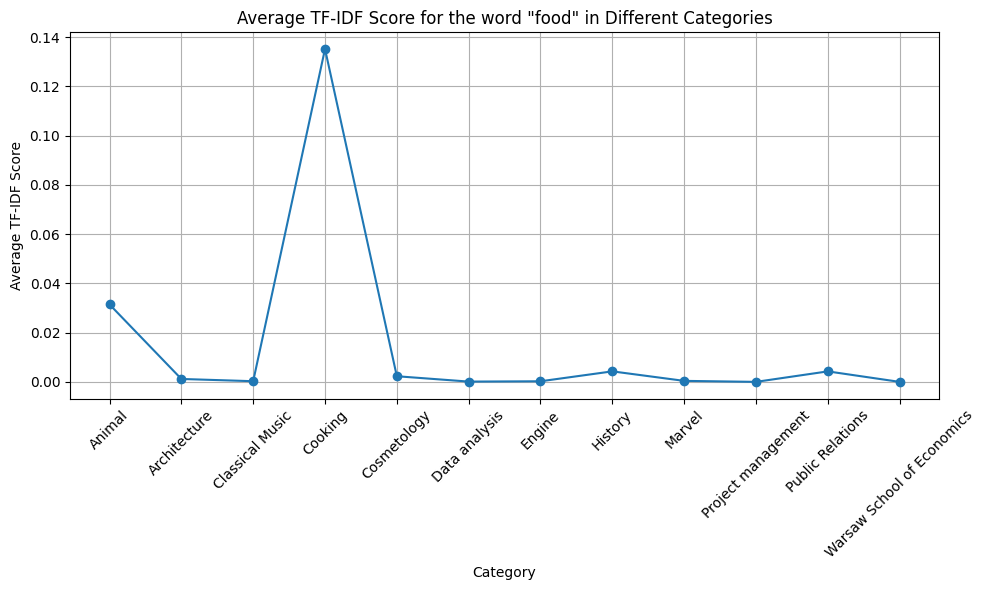

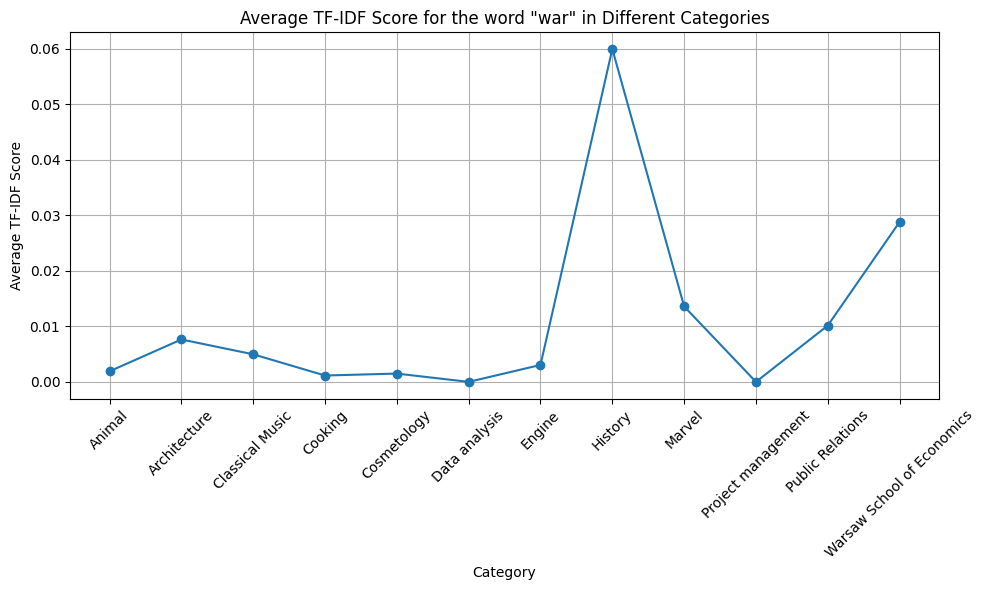

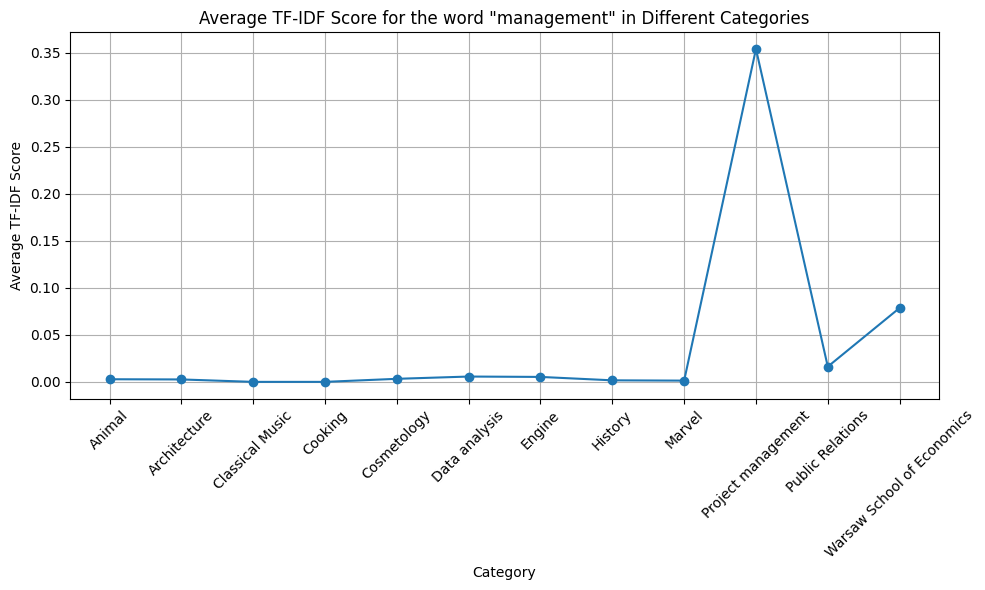

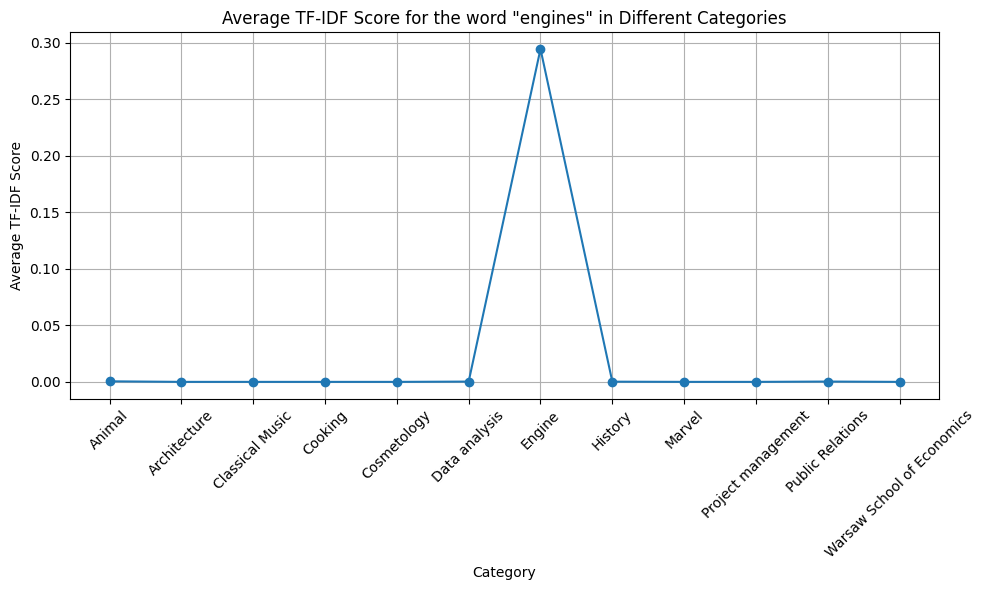

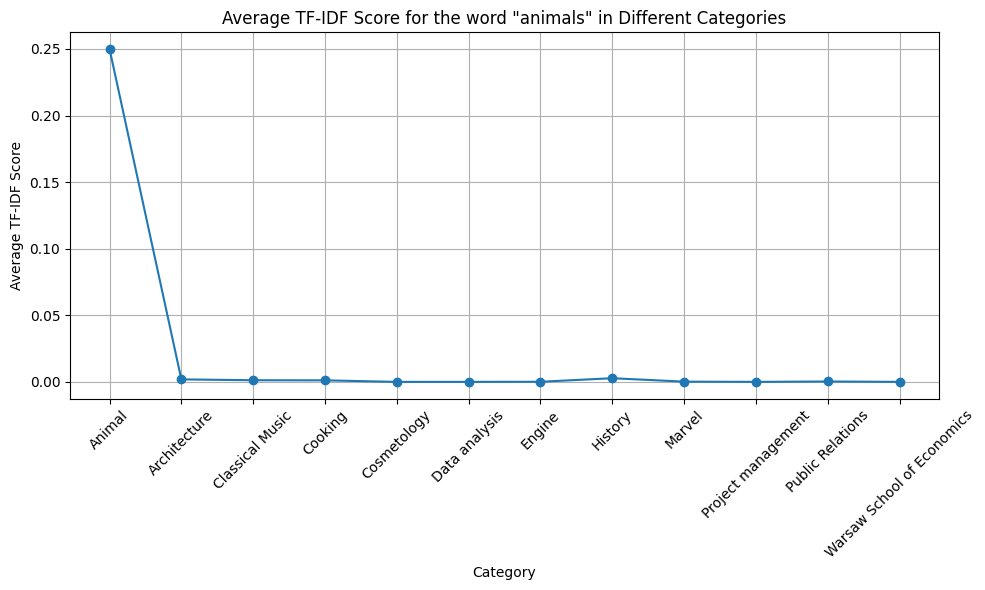

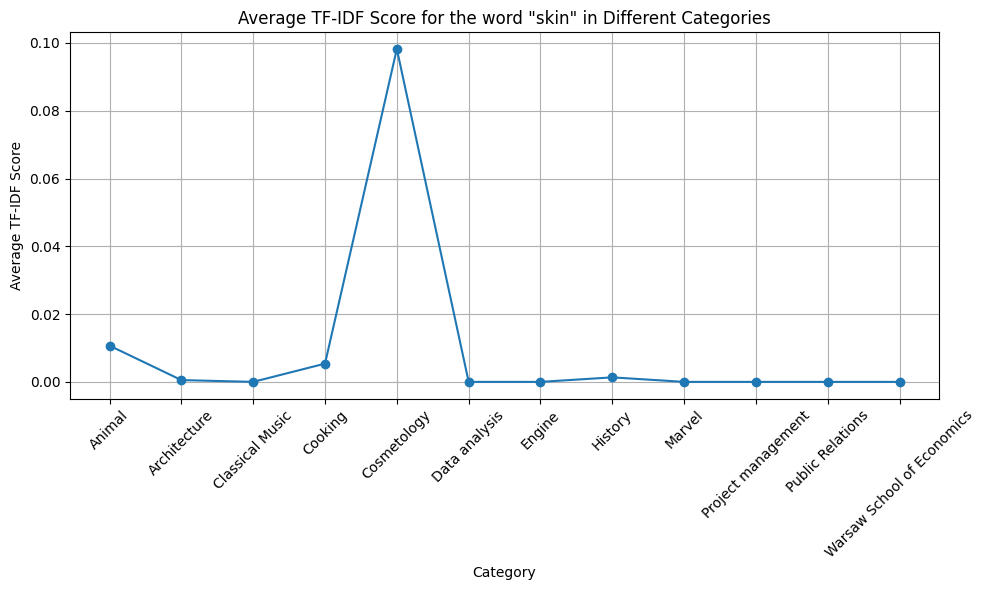

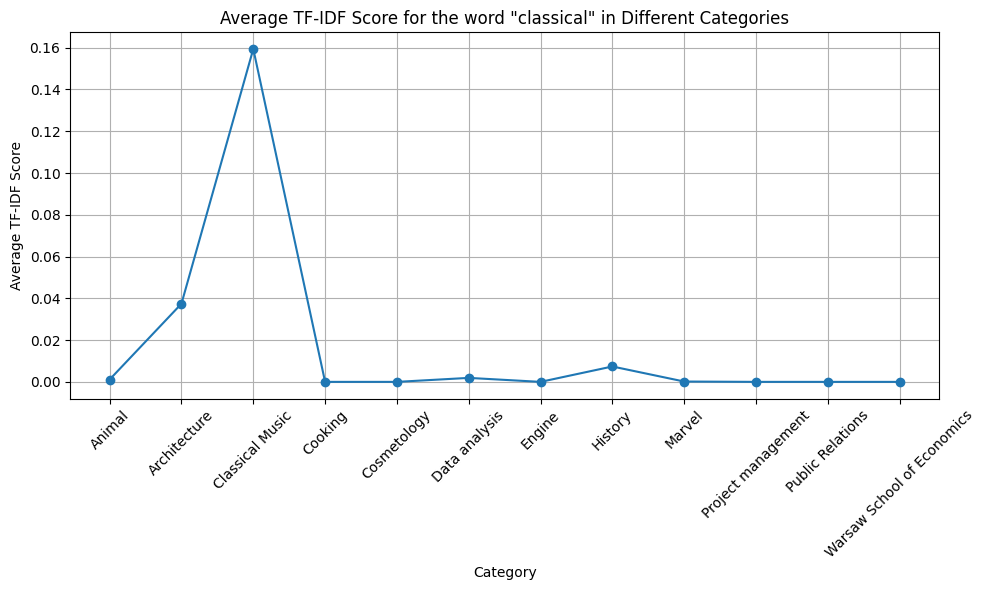

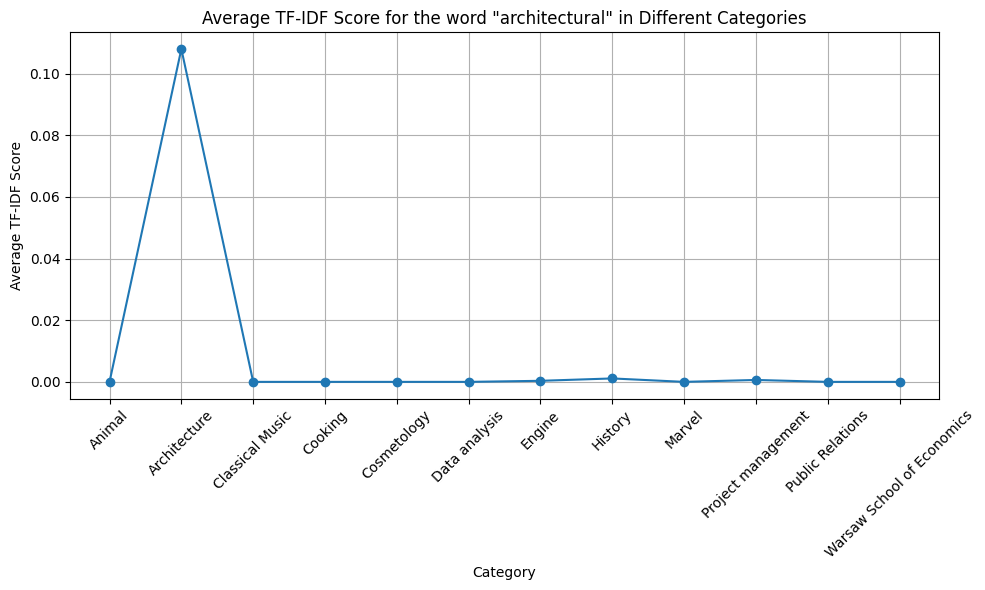

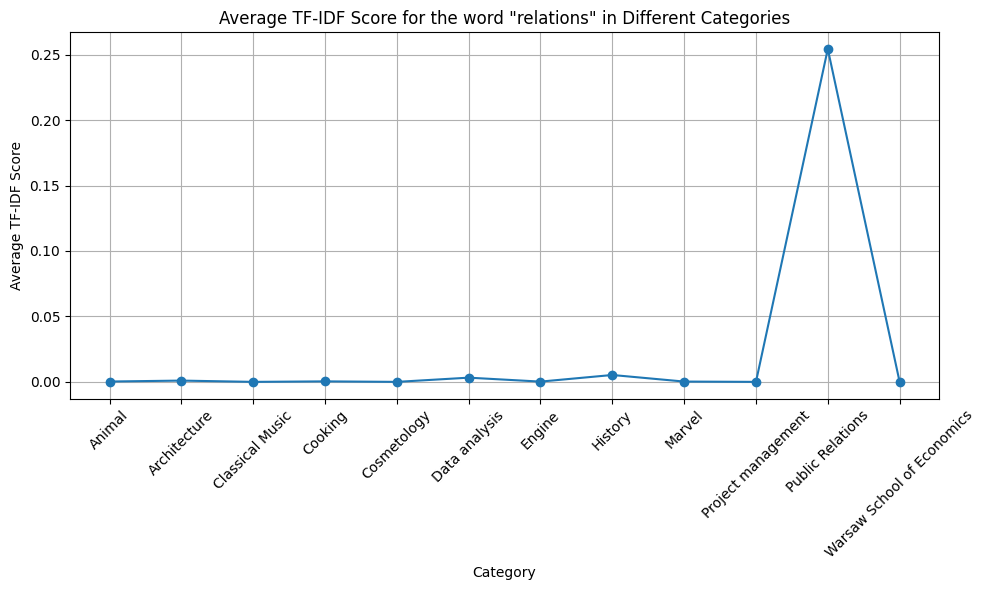

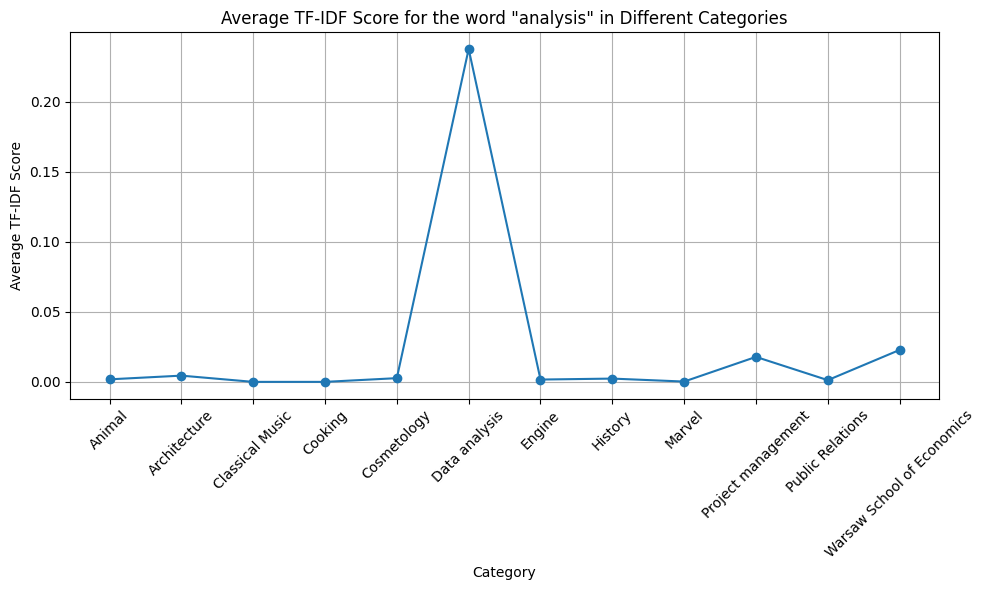

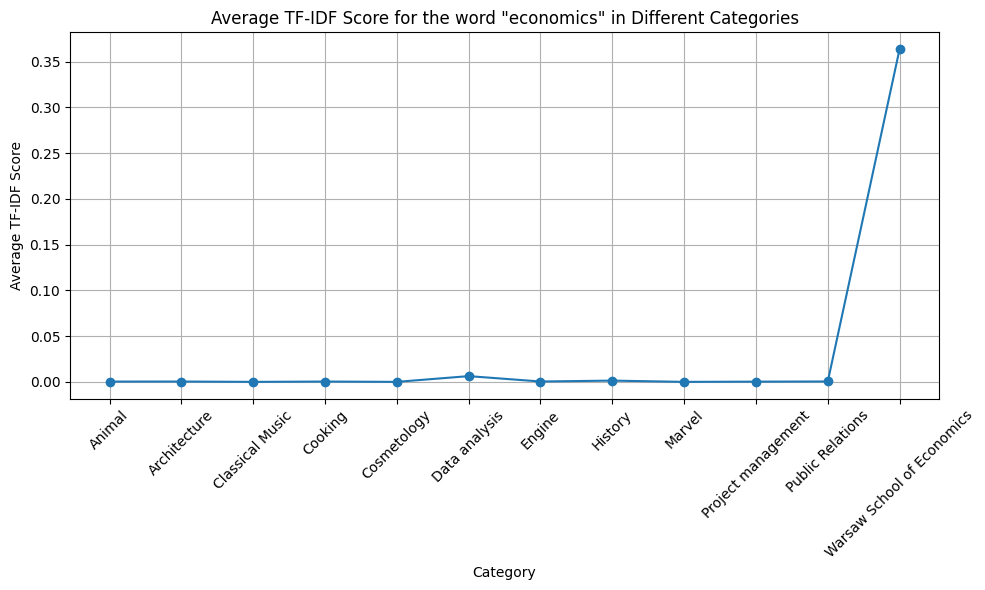

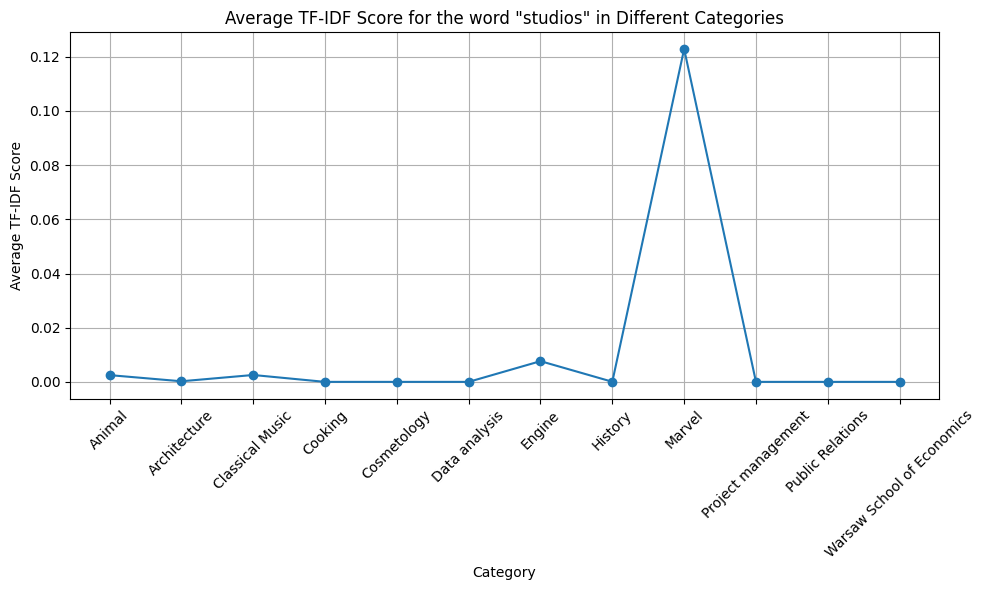

In [757]:
# Calculate the average TF-IDF score for the given word in each article
charts = records.copy()

get_top_keywords(charts, charts['Category_id'], 10, tfidf_vectorizer)

tf_idf_top_words_all_categories(charts)


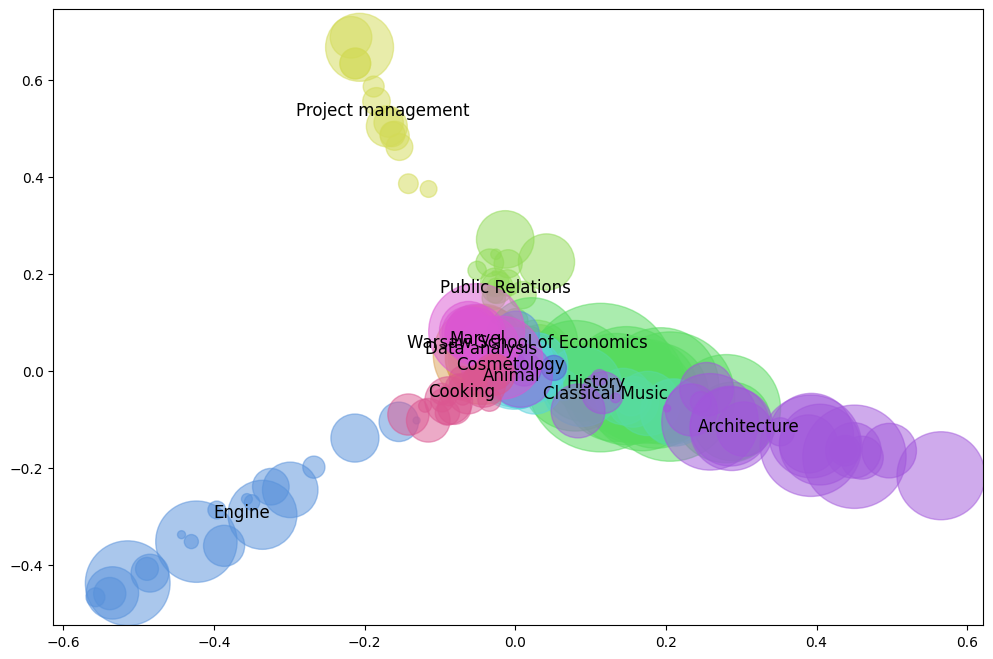

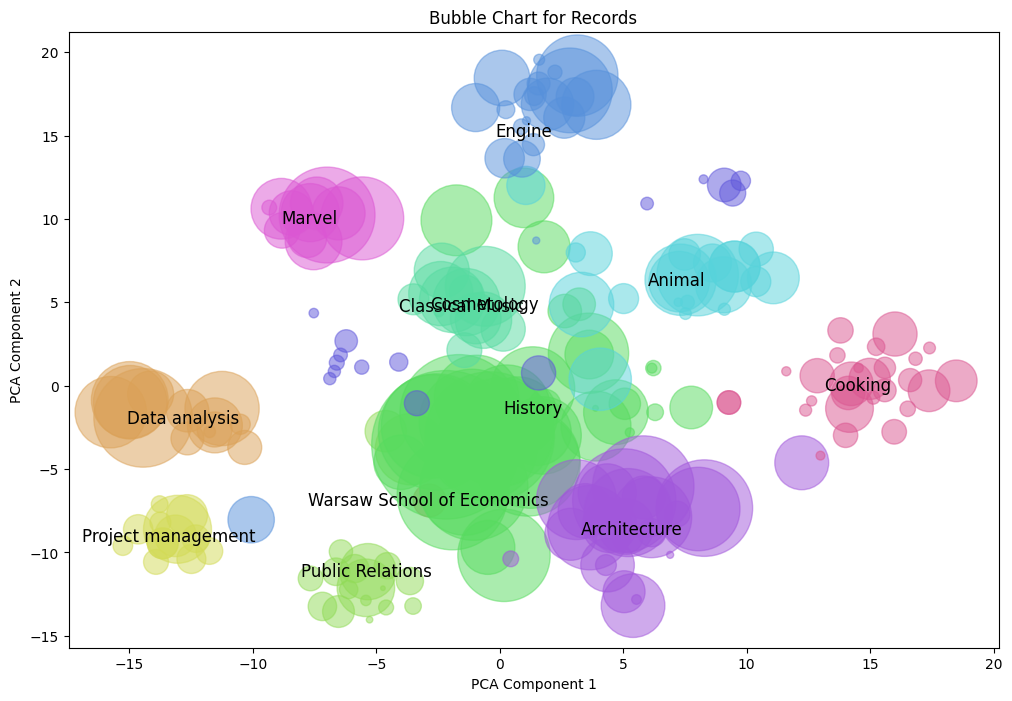

In [759]:
bubble_chart_categories(charts)

In [760]:
n_terms = 10  # Number of top words to get for each category
top_keywords = get_top_keywords(data, data['Category_id'], n_terms, tfidf_vectorizer)
display(HTML(f"<br />Top 10 key-words for eachcategory: <br /><br /> {top_keywords}"))

In [762]:
records_tfidf_list = records_tfidf.toarray().tolist()
data["TF-IDF"] = records_tfidf_list
data

Category                                      Article title  \
248             Cooking                  List of food preparation utensils   
49              History                                            History   
251             Cooking                              High-altitude cooking   
28   Project management                         Float (project management)   
145              Engine                         Search engine optimization   
..                  ...                                                ...   
166         Cosmetology                          Exfoliation (cosmetology)   
227             Cooking                                     Cooking banana   
241             Cooking                                        Cooking off   
39     Public Relations                          Public relations in India   
223              Marvel  List of Marvel Cinematic Universe television s...   

     Category_id                                            Content  \
248           11  A kitchen utensil is a hand-held, typically sm...   
49             4  History (derived from Ancient Greek  ἱστορία (...   
251           11  High-altitude cooking is cooking done at altit...   
28             2  In project management, float or slack is the a...   
145            7  Search engine optimization (SEO) is the proces...   
..           ...                                                ...   
166            8  Exfoliation is the removal of dead skin cells ...   
227           11  Cooking bananas are banana cultivars in the ge...   
241           11  Cooking off (or thermally induced firing) is u...   
39             3  Public relations is a term that refers to the ...   
223           10  The Marvel Cinematic Universe (MCU) television...   

                                                TF-IDF  \
248  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
49   [0.004529876908843396, 0.0, 0.0, 0.0, 0.0, 0.0...   
251  [0.0975356877795694, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
28   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0266081023714...   
145  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
166  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
227  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0042253387958...   
241  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
223  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...   

                                          Top_Keywords  
248  meat, used, foods, cook, sauce, water, tempera...  
49   jewish, period, timeline, bc, world, jews, cen...  
251  meat, used, foods, cook, sauce, water, tempera...  
28   management software, portfolio, projects, soft...  
145  cylinders, stroke, combustion, steam, game, pi...  
..                                                 ...  
166  beauty, cosmology, retrieved, school, cosmetic...  
227  meat, used, foods, cook, sauce, water, tempera...  
241  meat, used, foods, cook, sauce, water, tempera...  
39   journal, prsa, communications, communication, ...  
223  man, captain, film, films, disney, comics, ser...  

[216 rows x 6 columns]

In [763]:
records_k_means = __cluster_K_Means(records_tfidf, n_categories)
data["K-Means_Cluster_assignment_12K"] = records_k_means


n_terms = 10  # Number of top words to get for each category
top_keywords_KM12K = get_top_keywords(data, data["K-Means_Cluster_assignment_12K"], n_terms, tfidf_vectorizer)

In [764]:
display(HTML(f"<br />Top 10 key-words for each of 12 K-Means clusters: <br /><br /> {top_keywords_KM12K}"))

In [765]:
km_documents_in_clusters = get_documents_in_clusters(data, data["K-Means_Cluster_assignment_12K"], tfidf_vectorizer)
km_documents_in_clusters

Category_id       Category                      Article Title
0              7        Cooking  List of food preparation utensils
1              7        Cooking              High-altitude cooking
2              7        Cooking                      Cooking Light
3              7        Cooking                  Carryover cooking
4              7        Cooking                  Induction cooking
..           ...            ...                                ...
211           11  Data analysis                           Big data
212           11  Data analysis            Multivariate statistics
213           11  Data analysis          Data Analysis Expressions
214           11  Data analysis          Exploratory data analysis
215           11  Data analysis            Geometric data analysis

[216 rows x 3 columns]

In [766]:
data['KM12_Category'] = None
for j in enumerate(data.index):
    i = data["K-Means_Cluster_assignment_12K"][j[1]]
    x = km_documents_in_clusters.loc[km_documents_in_clusters['Category_id']==i]['Category'].unique()[0]
    data['KM12_Category'][j[1]] = x
    
for i in range(len(km_documents_in_clusters["Category_id"].unique())):
    df = pd.DataFrame(charts2.loc[data["K-Means_Cluster_assignment_12K"] == i][['K-Means_Cluster_assignment_12K', 'KM12_Category', 'Article title', 'Category']])
    display(HTML(df.to_html())) 

Wartości skorów sylwetki:  [0.024233927176118983, 0.03145742246543743, 0.04144743477888696, 0.059432309372651974, 0.06802540029739891, 0.07429568523269478, 0.07924256131336896, 0.10696867847996756, 0.11469670876410538, 0.10521764619093121, 0.11192185218515946, 0.11058376065101586, 0.11908753673791651, 0.08918557095567851, 0.10087073745407255, 0.11220381166492051, 0.10868850575065993]


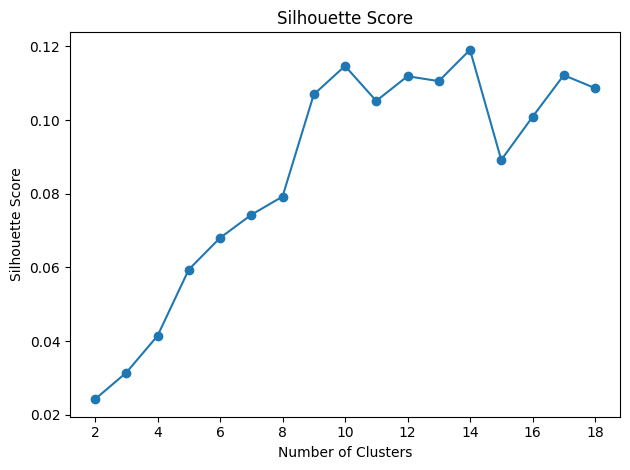

Wartości inertii:  [200.47089119513447, 196.13761178096604, 188.6961333847394, 183.24532336078428, 178.3082799128553, 173.32944331234677, 169.75696537064098, 164.3193361857226, 157.99067758187914, 159.04654284192765, 154.80643796313097, 155.05950659358587, 150.54277721388027, 147.80506540101592, 148.8569914152609, 147.46231357946152, 145.0749364947206]


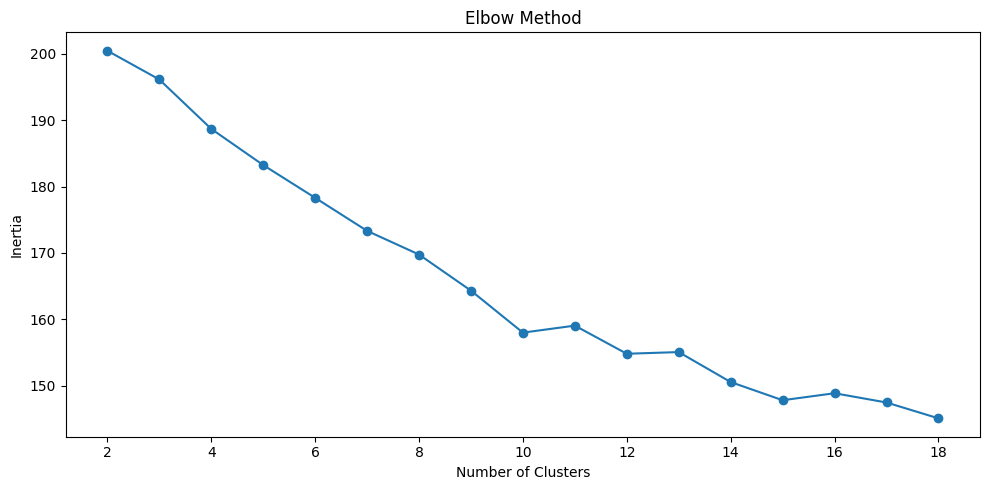

Wartości zeskalowanych inertii:  [1.0146308760272853, 1.013563738118515, 0.9973854452750275, 0.9908852001918919, 0.9868827380291628, 0.9826770897745891, 0.985308746245235, 0.9788725825487812, 0.9681044942623993, 0.9932378025309108, 0.9926236519785164, 1.0138539976886833, 1.0118949796692758, 1.0185850250590327, 1.0436991818658756, 1.0569186658878336, 1.0653119363240702]


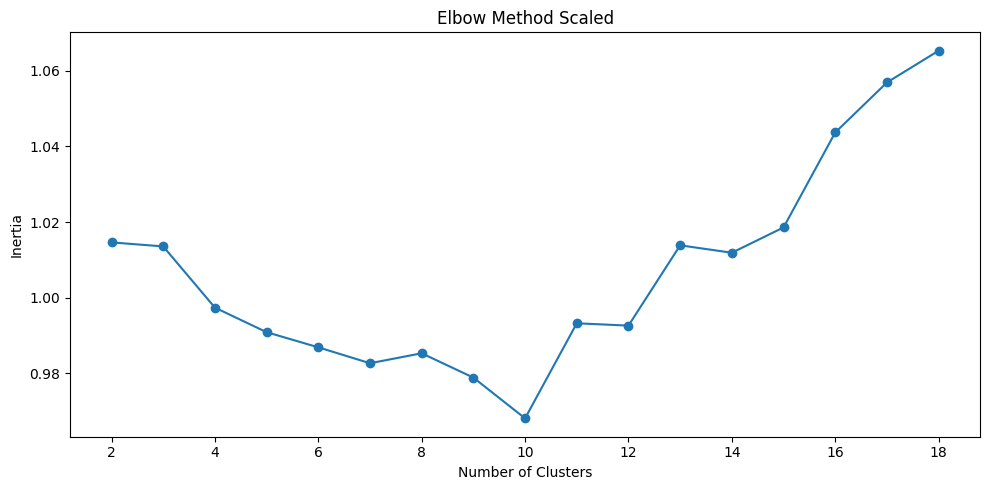

Optymalna liczba klastrów:  10


In [767]:
# Choose silhouette_weight to control the balance between the two scores
silhouette_weight = 0.6  # Adjust this value based on your preference
kmeans = cluster_K_Means(records_tfidf, silhouette_weight)

clustered_labels = kmeans.fit_predict(records_tfidf)

In [768]:
data["K-Means_Cluster_assignment"] = clustered_labels

n_terms = 10  # Number of top words to get for each category
top_keywords_KM = get_top_keywords(data, data["K-Means_Cluster_assignment"], n_terms, tfidf_vectorizer)

In [769]:
display(HTML(f"<br />Top 10 key-words for each K-Means cluster: <br /><br /> {top_keywords_KM}"))

In [770]:
km_documents_in_clusters = get_documents_in_clusters(data, data["K-Means_Cluster_assignment"], tfidf_vectorizer)
km_documents_in_clusters

Category_id Category                                      Article Title
0              3  Cooking                  List of food preparation utensils
1              3  Cooking                              High-altitude cooking
2              3  Cooking                                      Cooking Light
3              3  Cooking                                  Carryover cooking
4              3  Cooking                                  Induction cooking
..           ...      ...                                                ...
211            8   Marvel   Characters of the Marvel Cinematic Universe: A–L
212            8   Marvel                               Marvel Entertainment
213            8   Marvel            List of Marvel Cinematic Universe films
214            8   Marvel                                      Marvel Comics
215            8   Marvel  List of Marvel Cinematic Universe television s...

[216 rows x 3 columns]

In [771]:
charts2 = data.copy()
charts2['KM_Category'] = None
for j in enumerate(charts2.index):
    i = charts2['K-Means_Cluster_assignment'][j[1]]
    x = km_documents_in_clusters.loc[km_documents_in_clusters['Category_id']==i]['Category'].unique()[0]
    charts2['KM_Category'][j[1]] = x

In [772]:
for i in range(len(km_documents_in_clusters["Category_id"].unique())):
    df = pd.DataFrame(charts2.loc[charts2['K-Means_Cluster_assignment'] == i][['K-Means_Cluster_assignment', 'KM_Category', 'Article title', 'Category']])
    display(HTML(df.to_html())) 

In [664]:
df = pd.DataFrame(charts2.loc[charts2['K-Means_Cluster_assignment'] == 4][25:][['K-Means_Cluster_assignment', 'KM_Category', 'Article title', 'Category']])
display(HTML(df.to_html())) 

In [773]:
silhouette_KM = silhouette_score(records_tfidf, data["K-Means_Cluster_assignment"])
silhouette_KM

0.11452485817919632

In [774]:
kmeans.inertia_

158.5220762755306

In [775]:
from sklearn.metrics import davies_bouldin_score as db_score

db_score(records_tfidf.toarray(), data["K-Means_Cluster_assignment"])

2.9417566232053525

In [776]:
charts2

Category                                      Article title  \
248             Cooking                  List of food preparation utensils   
49              History                                            History   
251             Cooking                              High-altitude cooking   
28   Project management                         Float (project management)   
145              Engine                         Search engine optimization   
..                  ...                                                ...   
166         Cosmetology                          Exfoliation (cosmetology)   
227             Cooking                                     Cooking banana   
241             Cooking                                        Cooking off   
39     Public Relations                          Public relations in India   
223              Marvel  List of Marvel Cinematic Universe television s...   

     Category_id                                            Content  \
248           11  A kitchen utensil is a hand-held, typically sm...   
49             4  History (derived from Ancient Greek  ἱστορία (...   
251           11  High-altitude cooking is cooking done at altit...   
28             2  In project management, float or slack is the a...   
145            7  Search engine optimization (SEO) is the proces...   
..           ...                                                ...   
166            8  Exfoliation is the removal of dead skin cells ...   
227           11  Cooking bananas are banana cultivars in the ge...   
241           11  Cooking off (or thermally induced firing) is u...   
39             3  Public relations is a term that refers to the ...   
223           10  The Marvel Cinematic Universe (MCU) television...   

                                                TF-IDF  \
248  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
49   [0.004529876908843396, 0.0, 0.0, 0.0, 0.0, 0.0...   
251  [0.0975356877795694, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
28   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0266081023714...   
145  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
166  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
227  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0042253387958...   
241  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
223  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...   

                                          Top_Keywords  \
248  meat, used, foods, cook, sauce, water, tempera...   
49   jews, states, world, century, film, new, empir...   
251  meat, used, foods, cook, sauce, water, tempera...   
28   management software, portfolio, projects, soft...   
145  jews, states, world, century, film, new, empir...   
..                                                 ...   
166  jews, states, world, century, film, new, empir...   
227  meat, used, foods, cook, sauce, water, tempera...   
241  meat, used, foods, cook, sauce, water, tempera...   
39   journal, prsa, communications, communication, ...   
223  man, captain, film, films, disney, comics, ser...   

     K-Means_Cluster_assignment_12K       KM12_Category  \
248                               7             Cooking   
49                                9             History   
251                               7             Cooking   
28                                2  Project management   
145                               3              Engine   
..                              ...                 ...   
166                               9             History   
227                               7             Cooking   
241                               7             Cooking   
39                                5    Public Relations   
223                               6              Marvel   

     K-Means_Cluster_assignment         KM_Category  
248                           3             Cooking  
49            

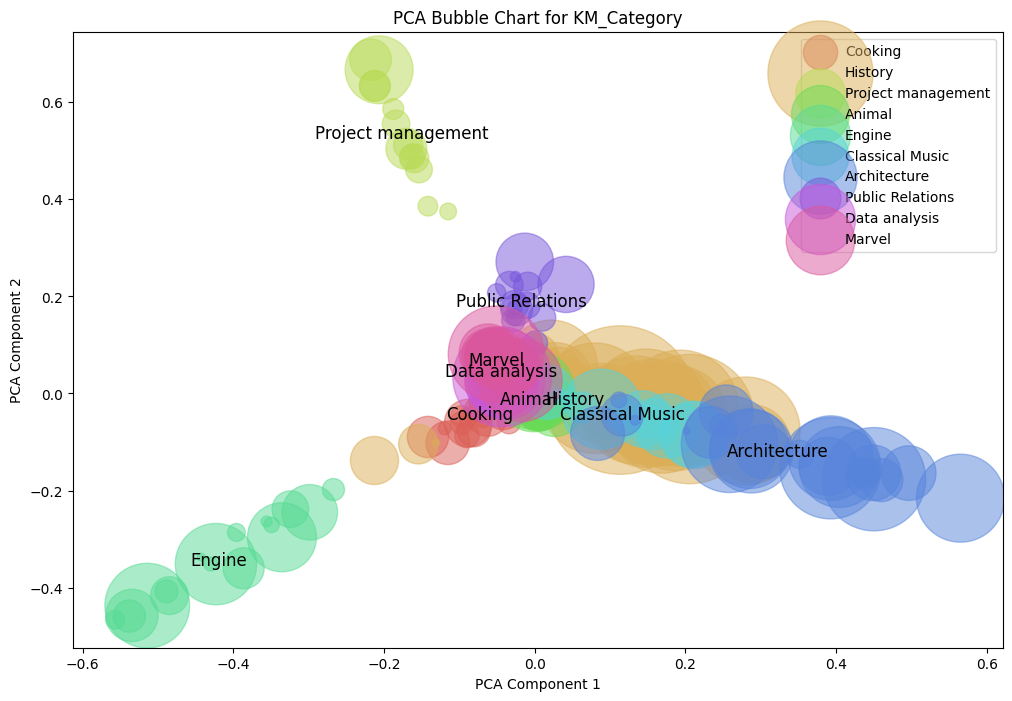

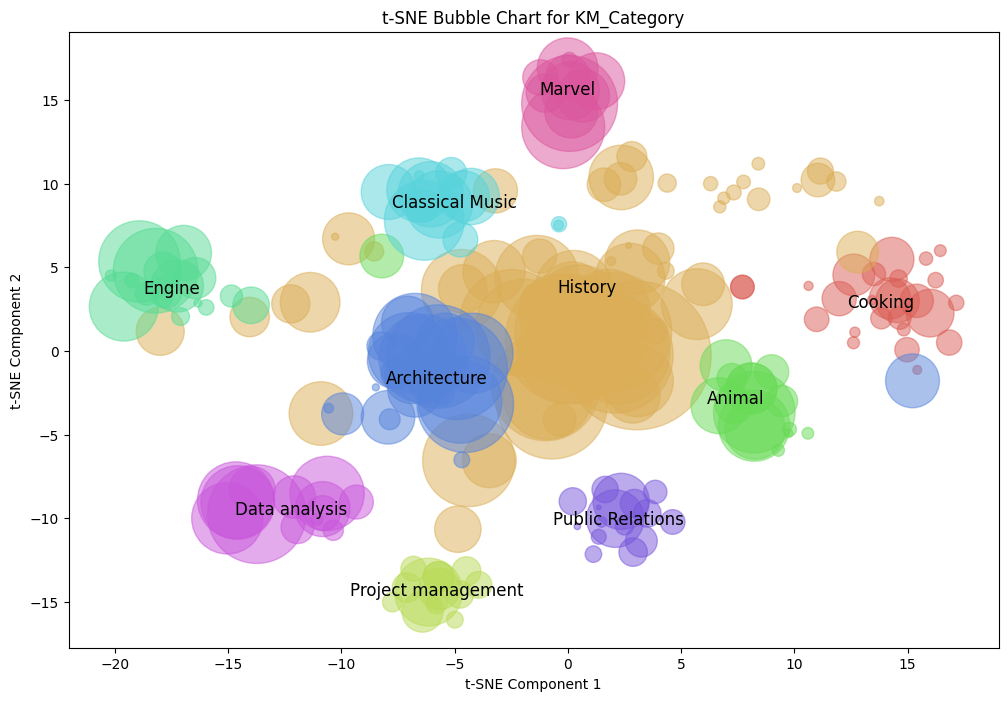

In [778]:
pca_kmeans(charts2)

In [650]:
#  DBSCAN 

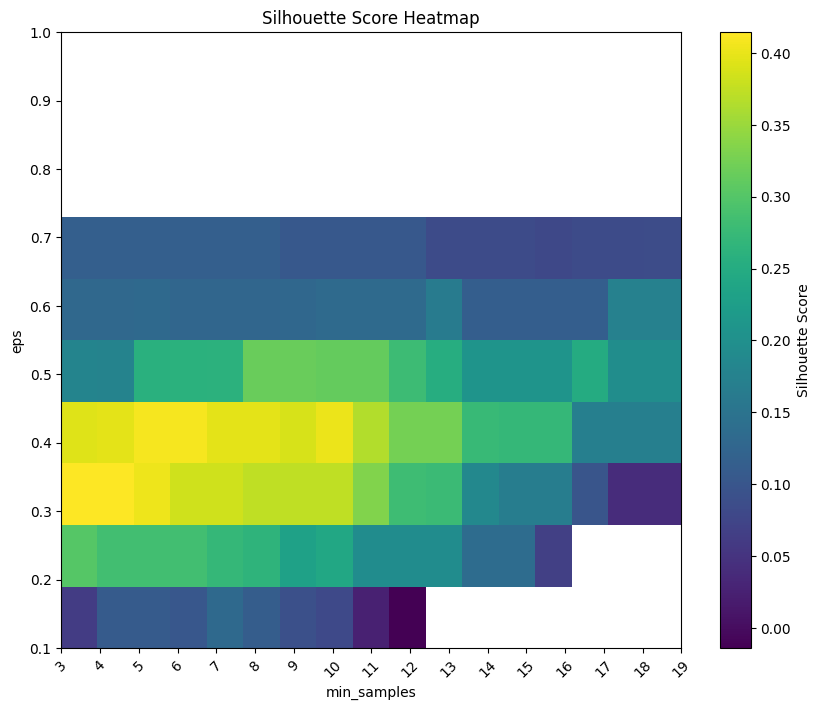

Best parameters: {'eps': 0.30000000000000004, 'min_samples': 3}


In [782]:
# Calculate cosine similarity matrix (optional)
cosine_similarities = cosine_similarity(records_tfidf)

dbscan_silhouette_based(cosine_similarities)

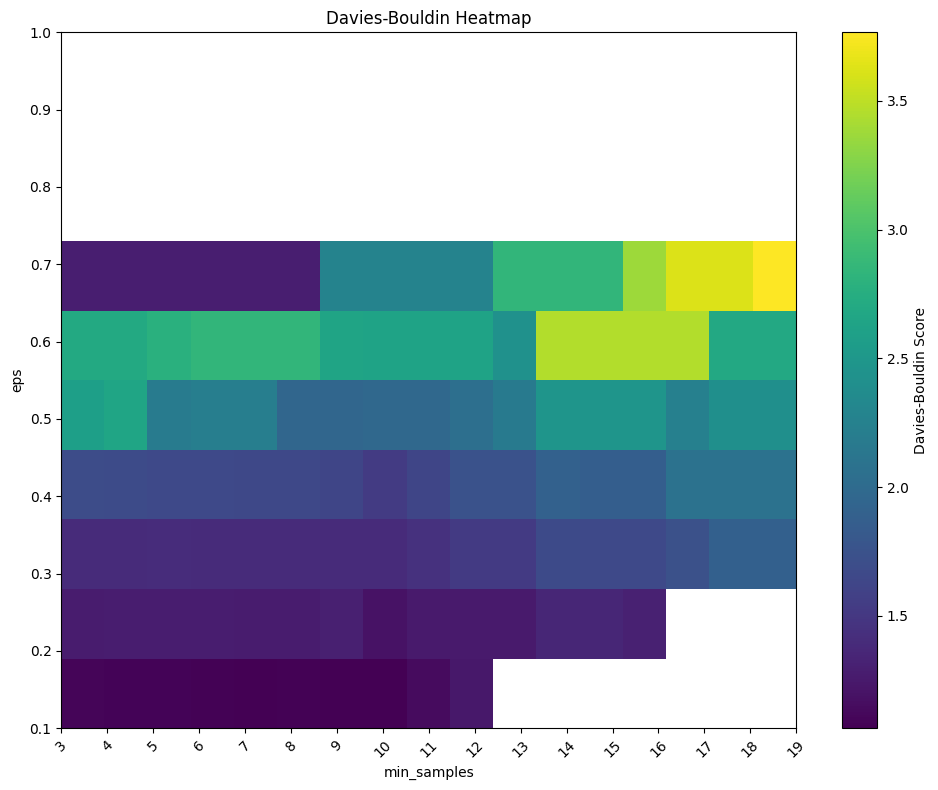

Best parameters: {'eps': 0.1, 'min_samples': 9}


In [785]:
dbscan_db_based(cosine_similarities)

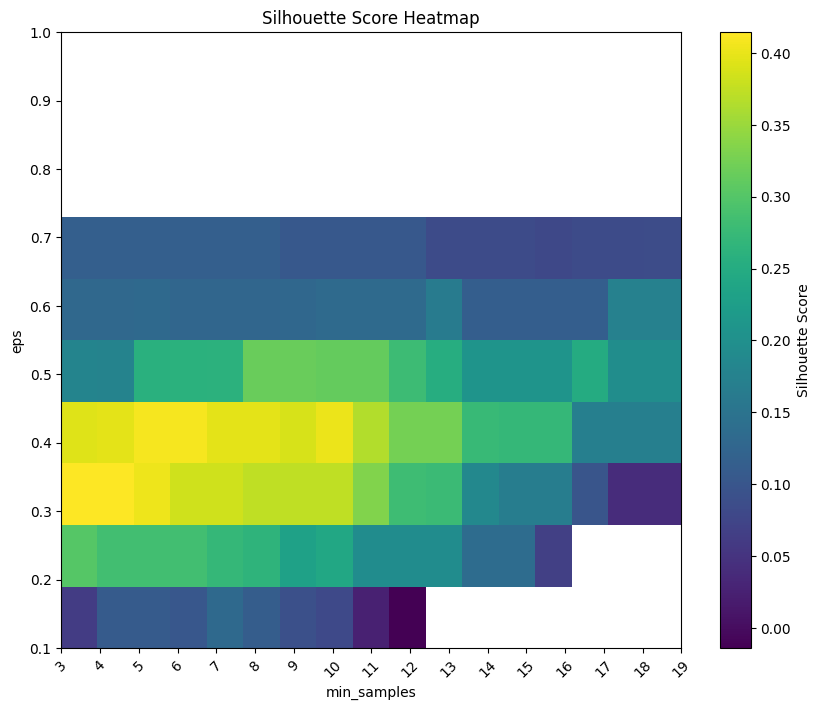

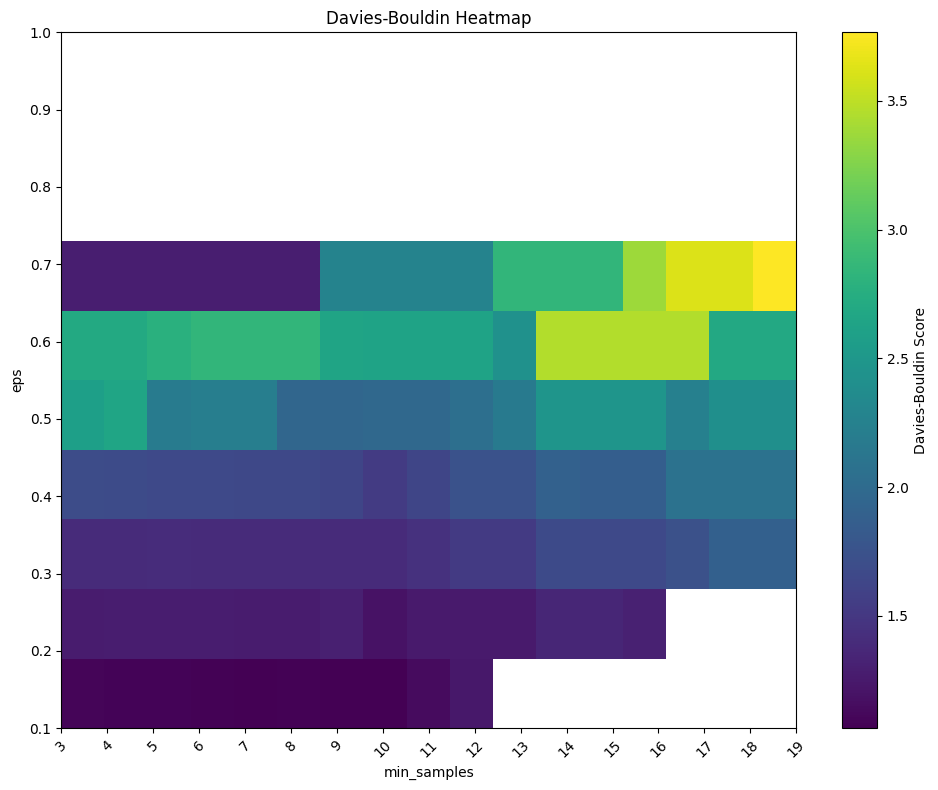

For hybrid_scores maximum at index (2, 0): eps=0.30, min_samples=3


In [787]:
dbscan = cluster_DBSCAN(records_tfidf, 0.5)

In [793]:
best_dbidx = db_score(cosine_similarities, dbscan)
best_dbidx

1.4003134180131265

In [794]:
charts2['dbs'] = dbscan

In [795]:
charts2

Category                                      Article title  \
248             Cooking                  List of food preparation utensils   
49              History                                            History   
251             Cooking                              High-altitude cooking   
28   Project management                         Float (project management)   
145              Engine                         Search engine optimization   
..                  ...                                                ...   
166         Cosmetology                          Exfoliation (cosmetology)   
227             Cooking                                     Cooking banana   
241             Cooking                                        Cooking off   
39     Public Relations                          Public relations in India   
223              Marvel  List of Marvel Cinematic Universe television s...   

     Category_id                                            Content  \
248           11  A kitchen utensil is a hand-held, typically sm...   
49             4  History (derived from Ancient Greek  ἱστορία (...   
251           11  High-altitude cooking is cooking done at altit...   
28             2  In project management, float or slack is the a...   
145            7  Search engine optimization (SEO) is the proces...   
..           ...                                                ...   
166            8  Exfoliation is the removal of dead skin cells ...   
227           11  Cooking bananas are banana cultivars in the ge...   
241           11  Cooking off (or thermally induced firing) is u...   
39             3  Public relations is a term that refers to the ...   
223           10  The Marvel Cinematic Universe (MCU) television...   

                                                TF-IDF  \
248  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
49   [0.004529876908843396, 0.0, 0.0, 0.0, 0.0, 0.0...   
251  [0.0975356877795694, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
28   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0266081023714...   
145  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
166  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
227  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0042253387958...   
241  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
223  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...   

                                          Top_Keywords  \
248  meat, used, foods, cook, sauce, water, tempera...   
49   jews, states, world, century, film, new, empir...   
251  meat, used, foods, cook, sauce, water, tempera...   
28   management software, portfolio, projects, soft...   
145  jews, states, world, century, film, new, empir...   
..                                                 ...   
166  jews, states, world, century, film, new, empir...   
227  meat, used, foods, cook, sauce, water, tempera...   
241  meat, used, foods, cook, sauce, water, tempera...   
39   journal, prsa, communications, communication, ...   
223  man, captain, film, films, disney, comics, ser...   

     K-Means_Cluster_assignment_12K       KM12_Category  \
248                               7             Cooking   
49                                9             History   
251                               7             Cooking   
28                                2  Project management   
145                               3              Engine   
..                              ...                 ...   
166                               9             History   
227                               7             Cooking   
241                               7             Cooking   
39                                5    Public Relations   
223                               6              Marvel   

     K-Means_Cluster_assignment         KM_Category      PCA1      PCA2  \
248                           3             Coo

In [802]:
best_silhouette = silhouette_score(cosine_similarities, dbscan, metric='cosine')
best_silhouette

0.4145895296006885

In [798]:
charts2['dbs'].nunique()

13

In [803]:
n_terms = 10  # Number of top words to get for each category
top_keywords_DBS = get_top_keywords(charts2, charts2["dbs"], n_terms, tfidf_vectorizer)
display(HTML(f"<br />Top 10 key-words for each DBSCAN cluster: <br /><br /> {top_keywords_DBS}"))

In [804]:
dbs_documents_in_clusters = get_documents_in_clusters(charts2, charts2["dbs"], tfidf_vectorizer)
dbs_documents_in_clusters
charts2['DBS_Category'] = None
for j in enumerate(charts2.index):
    i = charts2['dbs'][j[1]]
    if i==-1:
        continue
    x = dbs_documents_in_clusters.loc[dbs_documents_in_clusters['Category_id']==i]['Category'].unique() 
    x = x[0] if x else None
    charts2['DBS_Category'][j[1]] = x

In [805]:
df2 = charts2.copy()
df2['DBS_Category'] = df2['DBS_Category'].fillna('Missing')
df2['DBS_Category'].nunique() 

12

In [806]:

df_missing = df2.copy()
df_missing = pd.DataFrame(charts2.loc[charts2['dbs'] == -1][['dbs', 'DBS_Category', 'Article title', 'Category']])
df_missing['DBS_Category'] = df_missing['DBS_Category'].fillna('Missing')

df_missing = df_missing.sort_values('Category')
df_missing_1 = df_missing[:30]

display(HTML(df_missing_1.to_html())) 

In [807]:
df_missing_2 = df_missing[29:]
display(HTML(df_missing_2.to_html())) 

In [808]:
len(df_missing) # -1 cluster

58

In [809]:
for i in range(len(dbs_documents_in_clusters["Category_id"].unique())):
    df = pd.DataFrame(charts2.loc[charts2['dbs'] == i][['dbs', 'DBS_Category', 'Article title', 'Category']])
    display(HTML(df.to_html())) 

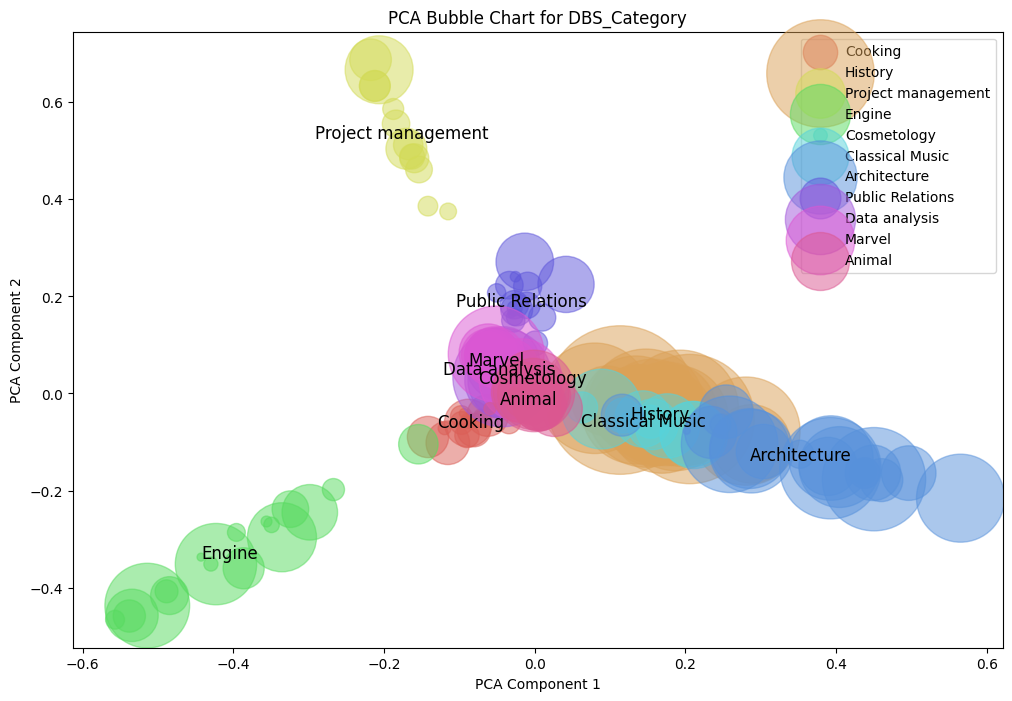

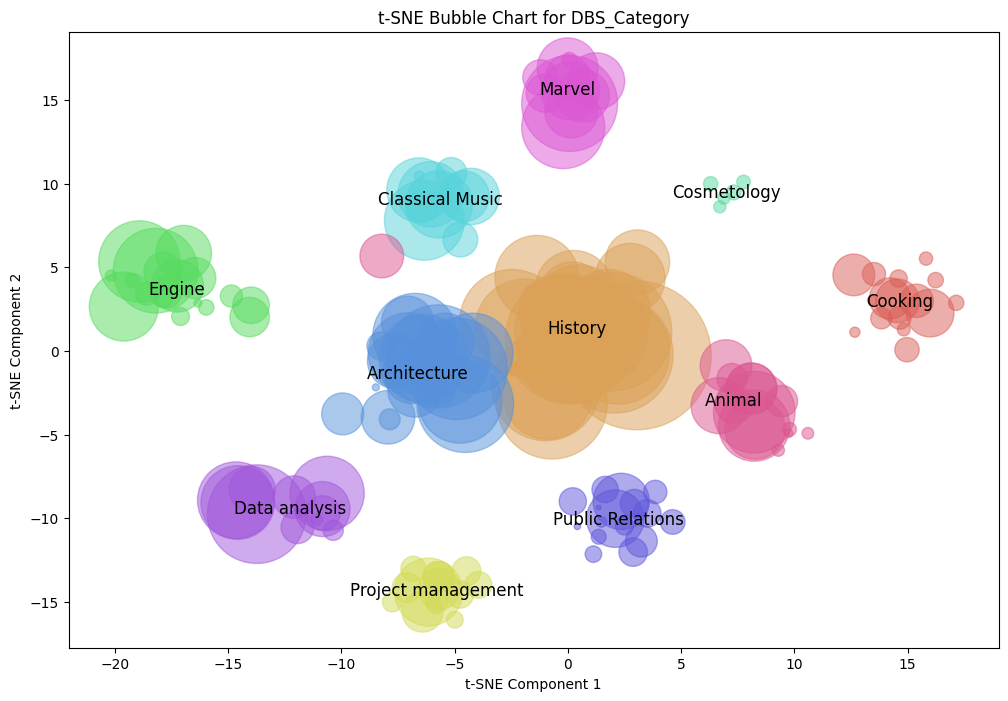

In [811]:
pca_dbscan(charts2)

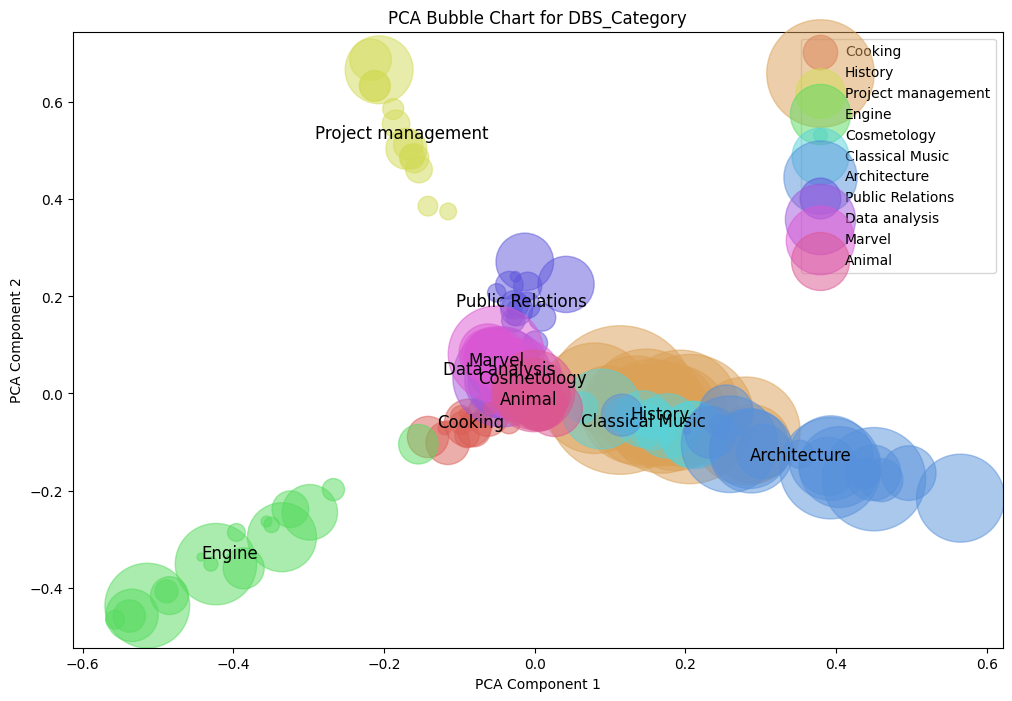

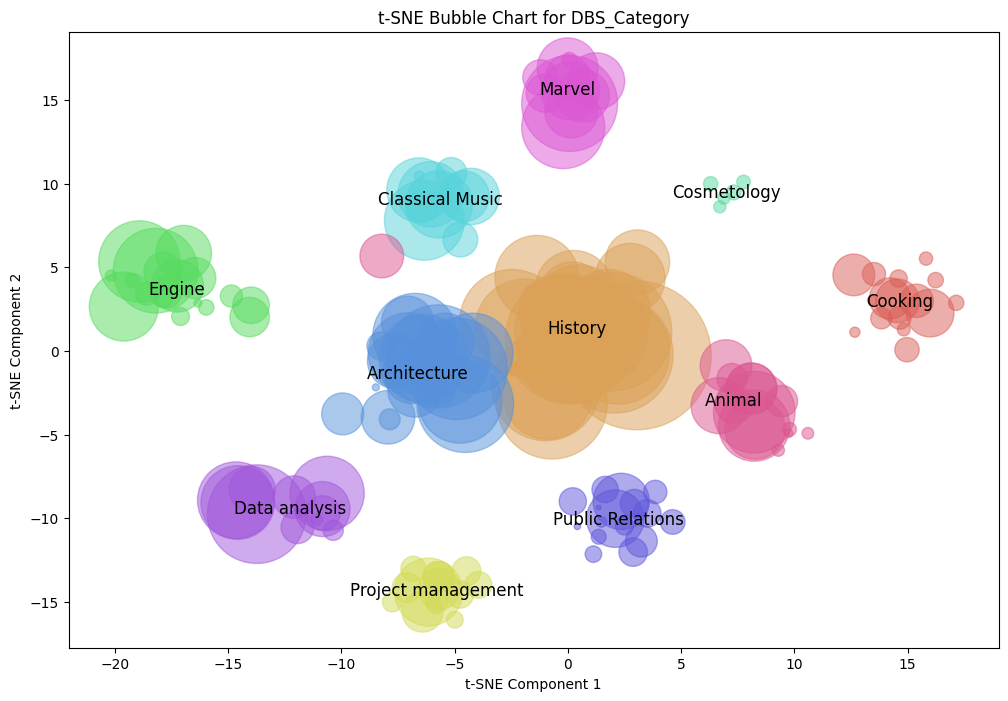

In [815]:
pca_dbscan_with_noise(charts2)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


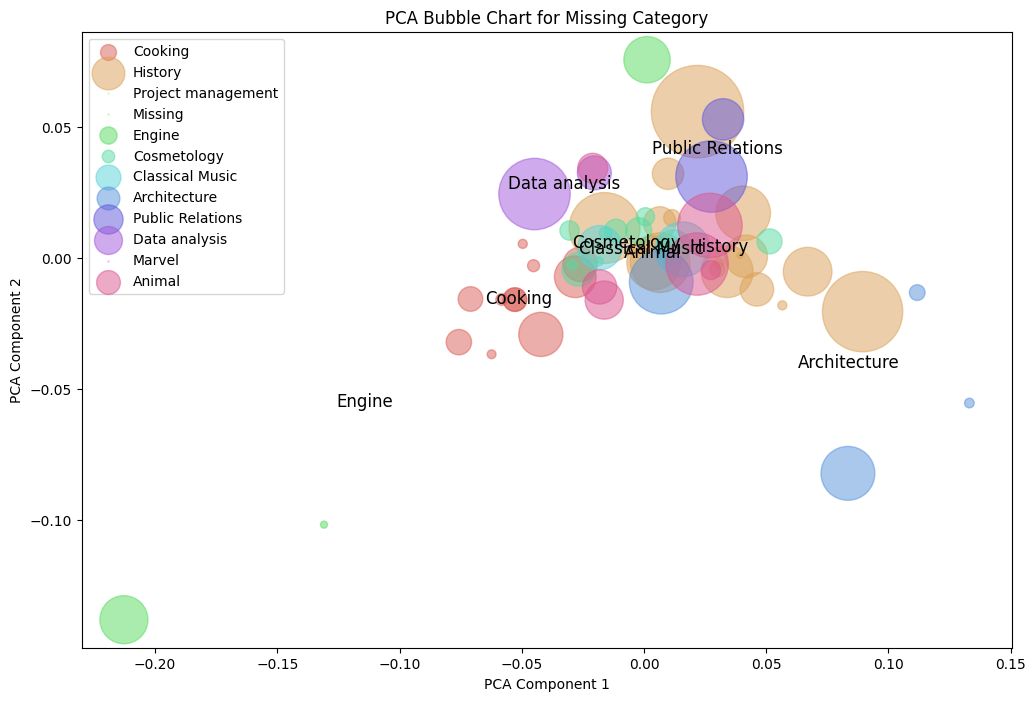

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


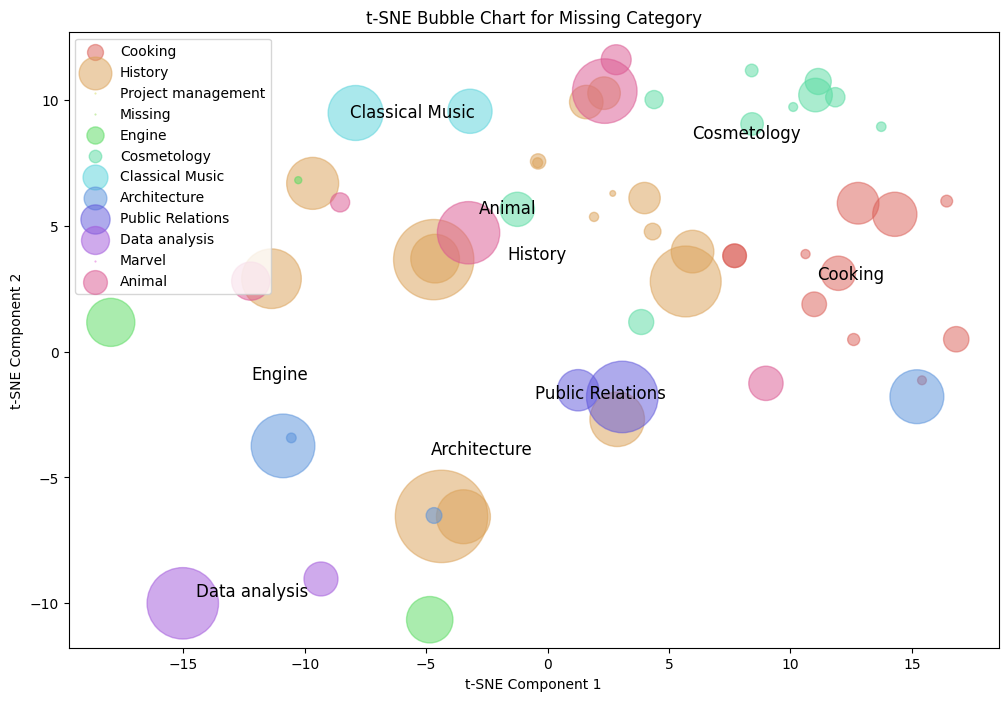

In [830]:
charts2['DBS_Category'] = charts2['DBS_Category'].fillna('Missing')
pca_dbscan_noise(charts2)

In [834]:
calculate_metrics(charts2)

K-Means Scores:
Silhouette Score: 0.11452485817919633
Davies-Bouldin Index: 2.9417566232053525
Adjusted Rand Index: 0.6563247037256265
Normalized Mutual Information: 0.8480513821794642

Adjusted Mutual Information: 0.8285281501798375
Homogeneity Score: 0.8058809491985691
Completeness Score: 0.8948789342651308
V-Measure Score: 0.8480513821794642

DBSCAN Scores:
Silhouette Score: 0.4145895296006885
Davies-Bouldin Index: 1.4003134180131265
Adjusted Rand Index: 0.49417380246889053
Normalized Mutual Information: 0.7763595186228305

Adjusted Mutual Information: 0.7402537794156917
Homogeneity Score: 0.7740284818212504
Completeness Score: 0.778704637970894
V-Measure Score: 0.7763595186228305
